# Graph Embeddings: Node Classification & Link Prediction
Massive Graph Management and Analytics

Authors: Olha Baliasina & Samuel Chapuis

We compare 9 embedding methods across 3 structurally different graphs, evaluating on node classification (NC) and link prediction (LP). Each unsupervised embedding is tested with two classifiers (LogReg, Random Forest) and two decoders (dot product, MLP) to separate embedding quality from downstream predictor choice.

Datasets:
- CA-HepTh — 10K authors, 22K edges, 7 research subfields from ArXiv cross-listings
- Amazon Co-Purchasing — 335K nodes, 926K edges, 12 product categories
- LastFM Asia — 7.6K users, 28K edges, 18 countries, with real 7842-dim node features

| # | Method | Paradigm | Learns from | NC | LP |
|---|--------|----------|------------|:--:|:--:|
| 1 | DeepWalk | Random walk + Word2Vec | Graph structure | ✓ | ✓ |
| 2 | Node2Vec | Biased walk + Word2Vec | Graph structure (BFS/DFS) | ✓ | ✓ |
| 3 | Spectral | Laplacian eigenvectors | Graph spectrum | ✓ | ✓ |
| 4 | DGI | Self-supervised GNN | Contrastive (no labels) | ✓ | ✓ |
| 5 | GRU-Walk | RNN walk encoder | Walk sequences | ✓ | ✓ |
| 6 | GraphSAGE | Supervised GNN | Labels + graph | ✓ | ✓ |
| 7 | GAT | Attention GNN | Labels + graph | ✓ | ✓ |
| 8 | TransE / DistMult | KG embeddings | Edge triples | ✓ | ✓ |
| 9 | VGAE | Variational autoencoder | Adjacency reconstruction | ✓ | ✓ |
| — | CN / Jaccard / Adamic-Adar | Heuristic baselines | Local structure | — | ✓ ||


---
# Part 0 — Setup

In [1]:
# 0.1 — Install (run once, restart runtime after)
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install -q torch-geometric
# %pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.0+cu121.html
# %pip install -q node2vec gensim umap-learn python-louvain python-igraph tqdm
print("All dependencies installed.")

All dependencies installed.


In [4]:
# 0.2 — Imports
import os, sys, time, warnings, pickle, random, gc, json, hashlib, ast
from pathlib import Path
from collections import Counter, defaultdict, deque
from itertools import combinations
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from scipy import sparse
from scipy.sparse.linalg import eigsh

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, average_precision_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import negative_sampling

from gensim.models import Word2Vec
import umap
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMB_DIM = 128
DATA_DIR = Path('/content/drive/MyDrive/MGMA_Part2/data')
print(f"PyTorch {torch.__version__} | PyG {torch_geometric.__version__} | {DEVICE}")

PyTorch 2.10.0+cu128 | PyG 2.7.0 | cuda


In [5]:
# 0.3 — Checkpoint system (Google Drive)
class CheckpointManager:
    def __init__(self, base_dir='checkpoints'):
        self.base_dir = Path(base_dir); self.base_dir.mkdir(exist_ok=True)
    def save(self, name, data, msg=""):
        p = self.base_dir / f'{name}.pkl'
        with open(p, 'wb') as f: pickle.dump(data, f)
        print(f"  ✓ Saved: {name} ({p.stat().st_size/1e6:.1f} MB)")
    def load(self, name):
        p = self.base_dir / f'{name}.pkl'
        if p.exists():
            with open(p, 'rb') as f: data = pickle.load(f)
            print(f"  ✓ Loaded: {name}")
            return data
        return None
    def exists(self, name): return (self.base_dir / f'{name}.pkl').exists()
    def save_model(self, name, model):
        torch.save(model.state_dict(), self.base_dir / f'{name}_model.pt')
    def load_model(self, name, model):
        p = self.base_dir / f'{name}_model.pt'
        if p.exists():
            model.load_state_dict(torch.load(p, map_location=DEVICE, weights_only=True)); return True
        return False
    def delete(self, name):
        p = self.base_dir / f'{name}.pkl'
        if p.exists(): p.unlink(); print(f"  Deleted: {name}")

from google.colab import drive
drive.mount('/content/drive')
ckpt = CheckpointManager('/content/drive/MyDrive/MGMA_Part2/checkpoints')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Part 1 — Dataset Loading

We picked three graphs that differ in what they give us to work with:

| | HepTh | Amazon | LastFM Asia |
|---|---|---|---|
| Domain | Academic collaboration | Product co-purchasing | Social network |
| Nodes | 10,397 | 334,863 | 7,624 |
| Edges | 22,243 | 925,872 | 27,806 |
| Avg degree | 4.3 | 5.5 | 7.3 |
| Labels | ArXiv subfield (14% labeled) | Product category (73%) | Country (100%) |
| Node features | None | None | 7842-dim artist preferences |

HepTh tests what happens when most nodes are unlabeled. Amazon tests scalability (335K nodes means some methods just can't run). LastFM is the only graph with real content features, so it lets us compare whether GNNs gain more from knowing what users like versus just knowing who they're connected to.


## 1.1 — HepTh Collaboration Network

Co-authorship graph from ArXiv's hep-th (high energy physics — theory) section. Two authors are connected if they wrote a paper together; edge weight counts co-authored papers.

For labels, we use the `subj_class` field from the paper metadata. When a paper is cross-listed to another ArXiv section (e.g. "Mathematical Physics" or "Quantum Algebra"), that tells us something about the author's actual research focus. We assign each author their most frequent cross-listing category. After filtering out categories with fewer than 30 authors, we get 7 classes covering 1,454 nodes (14% of the LCC).

14% might sound low, but standard semi-supervised benchmarks like Cora train on about 5% of nodes. The full graph is still used for message passing and unsupervised embedding — only the classification head sees the label split.

In [6]:
# ═══════════════════════════════════════════
# 1.1 — Load HepTh + real subj_class labels
# ═══════════════════════════════════════════
cached = ckpt.load('hepth_graph_v2')  # new checkpoint name — v2 = real labels
if cached is not None:
    G_hepth = cached['graph']
    hepth_labeled_nodes = cached['labeled_nodes']
    hepth_labels = cached['labels']
    hepth_nodes = cached['nodes_sorted']
    hepth_n2i = cached['node_to_idx']
    hepth_class_names = cached['class_names']
    print(f"HepTh: {G_hepth.number_of_nodes():,} nodes, {G_hepth.number_of_edges():,} edges")
    print(f"Labeled: {len(hepth_labeled_nodes)} nodes, {len(hepth_class_names)} classes")
else:
    meta_df = pd.read_csv(str(DATA_DIR / 'arxiv_hepth_meta.csv'))
    def safe_parse(x):
        try:
            parsed = ast.literal_eval(str(x))
            return [str(a).strip() for a in parsed if len(str(a).strip()) > 1] if isinstance(parsed, list) else []
        except: return []
    meta_df['authors_parsed'] = meta_df['authors_list'].apply(safe_parse)

    # Build co-authorship graph
    G_hepth_full = nx.Graph()
    for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Building HepTh"):
        for a, b in combinations(row['authors_parsed'], 2):
            if G_hepth_full.has_edge(a, b): G_hepth_full[a][b]['weight'] += 1
            else: G_hepth_full.add_edge(a, b, weight=1)
    G_hepth = G_hepth_full.subgraph(max(nx.connected_components(G_hepth_full), key=len)).copy()

    # Extract real labels from subj_class
    labeled_papers = meta_df[meta_df['subj_class'].notna()]
    author_fields = defaultdict(list)
    for _, row in labeled_papers.iterrows():
        parts = str(row['subj_class']).split(';')
        field = parts[1].strip() if len(parts) >= 2 else parts[0].strip()
        for author in row['authors_parsed']:
            if author in G_hepth: author_fields[author].append(field)

    # Majority vote per author, keep fields with >= 30 authors
    raw_labels = {a: Counter(fs).most_common(1)[0][0] for a, fs in author_fields.items()}
    field_counts = Counter(raw_labels.values())
    good_fields = sorted([f for f, c in field_counts.items() if c >= 30])
    field_to_idx = {f: i for i, f in enumerate(good_fields)}
    author_labels = {a: field_to_idx[f] for a, f in raw_labels.items() if f in field_to_idx}

    hepth_nodes = sorted(G_hepth.nodes())
    hepth_n2i = {n: i for i, n in enumerate(hepth_nodes)}
    hepth_labeled_nodes = sorted(author_labels.keys())
    hepth_labels = np.array([author_labels[n] for n in hepth_labeled_nodes])
    hepth_class_names = good_fields

    print(f"HepTh LCC: {G_hepth.number_of_nodes():,} nodes, {G_hepth.number_of_edges():,} edges")
    print(f"Labeled: {len(hepth_labeled_nodes)} ({100*len(hepth_labeled_nodes)/len(hepth_nodes):.1f}%), {len(good_fields)} classes")
    print(f"Classes: {good_fields}")
    ckpt.save('hepth_graph_v2', {
        'graph': G_hepth, 'labeled_nodes': hepth_labeled_nodes, 'labels': hepth_labels,
        'nodes_sorted': hepth_nodes, 'node_to_idx': hepth_n2i, 'class_names': hepth_class_names,
    })

Building HepTh:   0%|          | 0/29555 [00:00<?, ?it/s]

HepTh LCC: 10,397 nodes, 22,243 edges
Labeled: 1454 (14.0%), 7 classes
Classes: ['Algebraic Geometry', 'Differential Geometry', 'Exactly Solvable and Integrable', 'Mathematical Physics', 'Mesoscopic Systems and Quantum Hall', 'Quantum Algebra', 'Statistical Mechanics']
  ✓ Saved: hepth_graph_v2 (1.1 MB)


## 1.2 — Amazon Co-Purchasing Network

Edges connect products that are frequently bought together. Ground-truth communities come from SNAP and represent product categories at various levels of granularity — the raw file has about 75K overlapping communities, most of them tiny.

Since communities overlap, each node can belong to many categories. We assign each node to the community where it shares the most neighbors (i.e. the community that best explains its local connectivity). We then filter for communities with at least 1000 members, which leaves 20 candidate communities. After the single-label assignment, only 12 of those 20 actually "win" any nodes — the rest get absorbed by larger neighbors.

In [17]:
# ═══════════════════════════════════════════
# 1.2 — Load Amazon (fully checkpointed)
# ═══════════════════════════════════════════
cached = ckpt.load('amazon_graph_data')
if cached is not None:
    G_amazon = cached['G_amazon']
    amazon_labeled_nodes = cached['labeled_nodes']
    amazon_labels = cached['encoded_labels']
    amazon_nodes = cached['nodes_sorted']
    amazon_n2i = cached['node_to_idx']
    N_CLASSES_AMAZON = cached['top_k']
    print(f"Amazon: {G_amazon.number_of_nodes():,} nodes, {G_amazon.number_of_edges():,} edges")
    print(f"Labeled: {len(amazon_labeled_nodes):,}, Classes: {N_CLASSES_AMAZON}")
else:
    print("Loading Amazon co-purchasing network...")
    G_amazon = nx.read_edgelist(str(DATA_DIR/'com-amazon.ungraph.txt'), comments='#',
                                 delimiter='\t', create_using=nx.Graph(), nodetype=int)
    G_amazon.remove_edges_from(nx.selfloop_edges(G_amazon))
    communities = []
    with open(DATA_DIR/'com-amazon.all.dedup.cmty.txt') as f:
        for line in f:
            members = list(map(int, line.strip().split()))
            if len(members) >= 3: communities.append(members)
    node_to_comms = defaultdict(list)
    for idx, comm in enumerate(communities):
        for node in comm:
            if node in G_amazon: node_to_comms[node].append(idx)
    comm_sizes = Counter()
    for node, comms in node_to_comms.items():
        for c in comms: comm_sizes[c] += 1

    # # Coverage analysis — pick K from data
    # sorted_counts = sorted(comm_sizes.values(), reverse=True)
    # cumsum = np.cumsum(sorted_counts) / sum(sorted_counts)
    # for k in [5, 10, 15, 20, 30, 50]:
    #     print(f"  Top {k:>2} communities: covers {cumsum[k-1]*100:.1f}% of memberships")

    N_CLASSES_AMAZON = 20
    top_comms = [c for c, _ in comm_sizes.most_common(N_CLASSES_AMAZON) if comm_sizes[c] >= 1000]
    print("top_comms:", len(top_comms))
    top_set = set(top_comms); comm_to_label = {c: i for i, c in enumerate(top_comms)}
    node_labels = {}
    for node in G_amazon.nodes():
        if node not in node_to_comms: continue
        best_c, best_n = None, 0
        for c in node_to_comms[node]:
            if c not in top_set: continue
            n = sum(1 for nb in G_amazon.neighbors(node) if c in [cc for cc in node_to_comms.get(nb,[]) if cc in top_set])
            if n > best_n: best_c, best_n = c, n
        if best_c is not None: node_labels[node] = comm_to_label[best_c]

    # Coverage analysis — after single-label assignment
    label_counts = Counter(node_labels.values())
    sorted_counts = sorted(label_counts.values(), reverse=True)
    total_labeled = sum(sorted_counts)
    cumsum = np.cumsum(sorted_counts) / total_labeled
    for k in [5, 10, 15, 20, 30, 50, len(sorted_counts)]:
        if k <= len(sorted_counts):
            print(f"  Top {k:>3}: covers {cumsum[k-1]*100:.1f}% of {total_labeled:,} labeled nodes")

    amazon_labeled_nodes = sorted(node_labels.keys())
    amazon_labels = np.array([node_labels[n] for n in amazon_labeled_nodes])
    amazon_nodes = sorted(G_amazon.nodes())
    amazon_n2i = {n: i for i, n in enumerate(amazon_nodes)}
    ckpt.save('amazon_graph_data', {
        'G_amazon': G_amazon, 'labeled_nodes': amazon_labeled_nodes, 'encoded_labels': amazon_labels,
        'nodes_sorted': amazon_nodes, 'node_to_idx': amazon_n2i, 'top_k': N_CLASSES_AMAZON,
    })

Loading Amazon co-purchasing network...
top_comms: 20
  Top   5: covers 61.3% of 243,379 labeled nodes
  Top  10: covers 95.6% of 243,379 labeled nodes
  Top  12: covers 100.0% of 243,379 labeled nodes
  ✓ Saved: amazon_graph_data (28.3 MB)


20 largest communities (≥1000 members) selected; after single-label assignment 12 retain nodes, covering 243K labeled nodes.

The top 10 communities cover 96% of assignable nodes; all 12 active communities cover 100% (243K out of 335K total nodes). The remaining 91K nodes either belong to no community or only to very small ones.

## 1.3 — LastFM Asia Social Network

Users from Asian countries on LastFM, connected by mutual follows. Each user has a binary feature vector (7842 dimensions) indicating which artists they listen to, with an average of 395 active features per user. Labels are the user's country (18 classes, 100% labeled).

This is the only dataset with real node features. On HepTh and Amazon we had to engineer structural features (degree, clustering, PageRank, core number) and concatenate them with learned embeddings. Here the GNNs get actual content information — artist preferences — which lets us test whether knowing what people like helps more than knowing who they know.

In [9]:
# ═══════════════════════════════════════════
# 1.3 — Load LastFM Asia (new dataset)
# ═══════════════════════════════════════════
cached = ckpt.load('lastfm_graph_data')
if cached is not None:
    G_lastfm = cached['graph']
    lastfm_labeled_nodes = cached['labeled_nodes']
    lastfm_labels = cached['labels']
    lastfm_nodes = cached['nodes_sorted']
    lastfm_n2i = cached['node_to_idx']
    lastfm_native_features = cached['native_features']
    print(f"LastFM: {G_lastfm.number_of_nodes():,} nodes, {G_lastfm.number_of_edges():,} edges")
    print(f"Labels: {len(set(lastfm_labels))} classes, Features: {lastfm_native_features.shape[1]}d")
else:
    edges_df = pd.read_csv(str(DATA_DIR / 'lastfm_asia_edges.csv'))
    targets_df = pd.read_csv(str(DATA_DIR / 'lastfm_asia_target.csv'))
    with open(DATA_DIR / 'lastfm_asia_features.json') as f:
        features_raw = json.load(f)

    G_lastfm = nx.Graph()
    G_lastfm.add_edges_from(zip(edges_df['node_1'], edges_df['node_2']))
    G_lastfm.remove_edges_from(nx.selfloop_edges(G_lastfm))

    # Build dense feature matrix from sparse binary features
    n_nodes = len(targets_df)
    max_feat = max(max(v) for v in features_raw.values() if len(v) > 0) + 1
    X_native = np.zeros((n_nodes, max_feat), dtype=np.float32)
    for node_str, feat_ids in features_raw.items():
        if len(feat_ids) > 0:
            X_native[int(node_str), feat_ids] = 1.0

    lastfm_nodes = sorted(G_lastfm.nodes())
    lastfm_n2i = {n: i for i, n in enumerate(lastfm_nodes)}
    lastfm_labeled_nodes = list(targets_df['id'].values)
    lastfm_labels = targets_df['target'].values
    lastfm_native_features = X_native

    print(f"LastFM: {G_lastfm.number_of_nodes():,} nodes, {G_lastfm.number_of_edges():,} edges")
    print(f"Labels: {len(set(lastfm_labels))} classes, 100% labeled")
    print(f"Native features: {X_native.shape[1]}d sparse binary (avg {X_native.sum(1).mean():.0f} active per node)")
    ckpt.save('lastfm_graph_data', {
        'graph': G_lastfm, 'labeled_nodes': lastfm_labeled_nodes, 'labels': lastfm_labels,
        'nodes_sorted': lastfm_nodes, 'node_to_idx': lastfm_n2i,
        'native_features': lastfm_native_features,
    })

LastFM: 7,624 nodes, 27,806 edges
Labels: 18 classes, 100% labeled
Native features: 7842d sparse binary (avg 395 active per node)
  ✓ Saved: lastfm_graph_data (239.9 MB)


## 1.4 — Structural overview

Degree distributions and class balance across the three graphs. Amazon has the heaviest tail (a few products with thousands of co-purchases). LastFM has the most severe class imbalance (smallest country has 16 users, largest has 1,572).

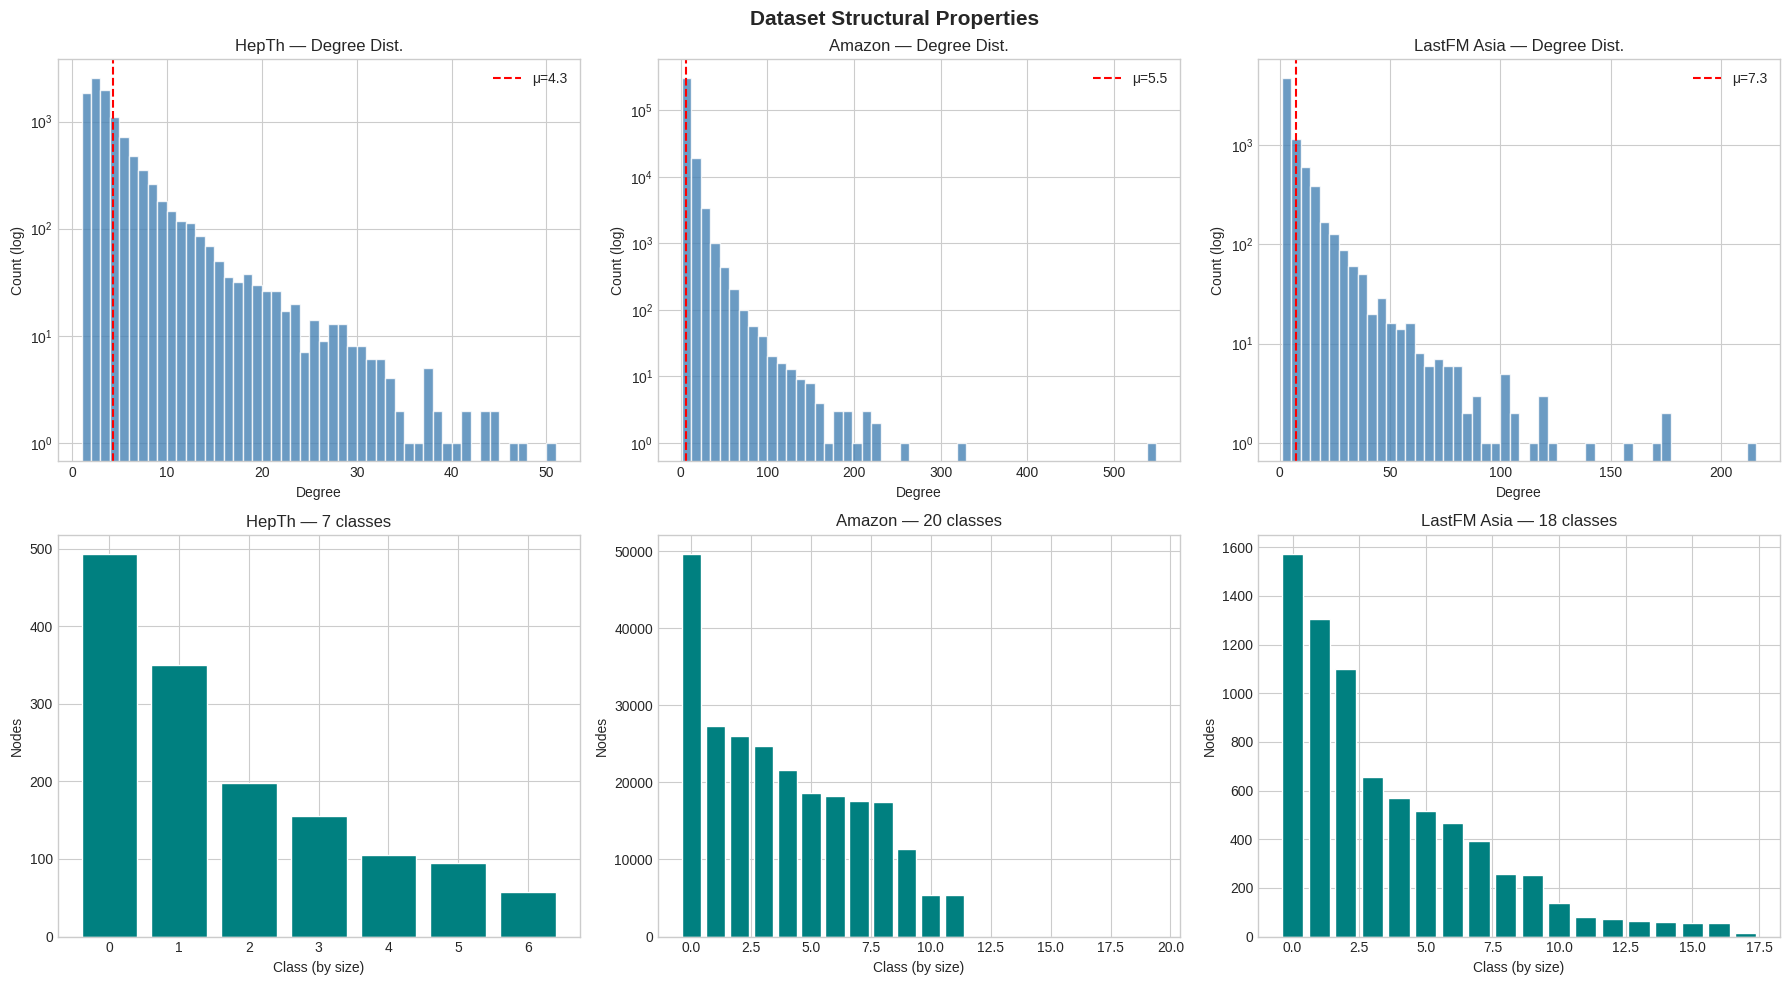

                            HepTh       Amazon       LastFM
----------------------------------------------------------
               Nodes        10397       334863         7624
               Edges        22243       925872        27806
          Avg degree 4.278734250264499 5.529855493141971 7.2943336831059815
             Classes            7           20           18
           Labeled %          14%          73%         100%
       Node features           No           No        7842d


In [18]:
# ═══════════════════════════════════════════
# 1.4 — Structural analysis & comparison
# ═══════════════════════════════════════════
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Dataset Structural Properties", fontsize=15, fontweight='bold')

datasets = [
    (G_hepth, "HepTh", hepth_labels, hepth_labeled_nodes),
    (G_amazon, "Amazon", amazon_labels, amazon_labeled_nodes),
    (G_lastfm, "LastFM Asia", lastfm_labels, lastfm_labeled_nodes),
]
for col, (G, name, labels, _) in enumerate(datasets):
    degrees = [d for _, d in G.degree()]
    ax = axes[0, col]
    ax.hist(degrees, bins=50, color='steelblue', edgecolor='white', alpha=0.8, log=True)
    ax.axvline(np.mean(degrees), color='red', ls='--', label=f'μ={np.mean(degrees):.1f}')
    ax.set_xlabel('Degree'); ax.set_ylabel('Count (log)'); ax.set_title(f'{name} — Degree Dist.'); ax.legend()

    ax = axes[1, col]
    cc = sorted(np.bincount(labels), reverse=True)
    ax.bar(range(len(cc)), cc, color='teal', edgecolor='white')
    ax.set_xlabel('Class (by size)'); ax.set_ylabel('Nodes'); ax.set_title(f'{name} — {len(cc)} classes')

plt.tight_layout(); plt.savefig('dataset_analysis.png', dpi=150, bbox_inches='tight'); plt.show()

# Summary table
print(f"{'':>20} {'HepTh':>12} {'Amazon':>12} {'LastFM':>12}")
print("-" * 58)
for label, vals in [
    ('Nodes', [G_hepth.number_of_nodes(), G_amazon.number_of_nodes(), G_lastfm.number_of_nodes()]),
    ('Edges', [G_hepth.number_of_edges(), G_amazon.number_of_edges(), G_lastfm.number_of_edges()]),
    ('Avg degree', [2*G_hepth.number_of_edges()/G_hepth.number_of_nodes(),
                    2*G_amazon.number_of_edges()/G_amazon.number_of_nodes(),
                    2*G_lastfm.number_of_edges()/G_lastfm.number_of_nodes()]),
    ('Classes', [len(set(hepth_labels)), N_CLASSES_AMAZON, len(set(lastfm_labels))]),
    ('Labeled %', [f"{100*len(hepth_labeled_nodes)/len(hepth_nodes):.0f}%",
                   f"{100*len(amazon_labeled_nodes)/len(amazon_nodes):.0f}%", "100%"]),
    ('Node features', ['No', 'No', '7842d']),
]:
    print(f"{label:>20} {str(vals[0]):>12} {str(vals[1]):>12} {str(vals[2]):>12}")

---
# Part 2 — The Embedding-to-Prediction Pipeline

This is the part our professor kept coming back to: what produces the embedding and what uses it for the task are two separate choices. Mixing them up is the most common mistake in graph ML evaluation.

Unsupervised methods (DeepWalk, Node2Vec, Spectral, DGI, GRU-Walk) learn embeddings without any labels. The embedding is then frozen and handed to a downstream predictor. For NC that means LogReg or Random Forest on top. For LP that means dot product or MLP decoder. Same embedding, different predictor — and the results can differ a lot (on HepTh, switching from LogReg to RF on Node2Vec jumps F1 from 0.59 to 0.76).

Supervised GNNs (GraphSAGE, GAT) are trained end-to-end for NC with cross-entropy loss. For LP, we use the GNN as an encoder paired with a decoder, trained jointly with binary cross-entropy on positive/negative edges.

KG embeddings (TransE, DistMult) were designed for multi-relational knowledge graphs, but they still produce entity embeddings. For LP they use their native scoring functions ($-\|h + r - t\|$ for TransE, $h^T \text{diag}(r) \, t$ for DistMult). For NC we just feed the learned entity embeddings into LogReg/RF — testing whether a translational or bilinear training signal captures class structure at all. We skip TransH and TransR because their innovations (relation-specific hyperplanes and projections) only help when you have multiple relation types.

GRU-Walk replaces Word2Vec with a GRU to process random walks. The motivation is that Skip-Gram treats each (center, context) pair independently, while a GRU sees the walk as a sequence. If local ordering in walks carries information, GRU-Walk should pick it up.

VGAE directly reconstructs the adjacency matrix via $\hat{A} = \sigma(ZZ^T)$. This makes link prediction the training objective itself, not a downstream task. The latent vectors $\mu$ can also be used for NC.

We test two classifiers (LogReg, RF) and two decoders (dot product, MLP) to separate embedding quality from predictor quality. If RF consistently beats LogReg on the same embedding, the class boundaries are nonlinear. If MLP beats dot product, the edge structure isn't captured by simple inner products.


---
# Part 3 — Model Implementations

All model architectures and training functions defined here. Hyperparameters are fixed across datasets unless noted: embedding dimension = 128, walk length = 40, walks per node = 10, Skip-Gram window = 5. GNNs use 2 layers with batch normalization and dropout 0.5, trained with early stopping (patience = 30). Class-weighted cross-entropy for NC to handle label imbalance.

In [19]:
# ═══════════════════════════════════════════
# 3.1 — Shallow embedding methods
# ═══════════════════════════════════════════

# --- DeepWalk ---
# walk_length=40 (covers 2-3 community diameters)
# num_walks=10 per node (coverage vs speed)
# window=5 (Skip-Gram context ≈ 2-hop neighborhood)

def deepwalk(G, dim=128, walk_length=40, num_walks=10, window=5, workers=4):
    random.seed(SEED); nodes = list(G.nodes()); walks = []
    for _ in tqdm(range(num_walks), desc="DeepWalk walks"):
        random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            for _ in range(walk_length - 1):
                nbrs = list(G.neighbors(walk[-1]))
                if not nbrs: break
                walk.append(random.choice(nbrs))
            walks.append([str(n) for n in walk])
    print(f"  Training Word2Vec on {len(walks):,} walks...")
    model = Word2Vec(walks, vector_size=dim, window=window, min_count=0,
                     sg=1, workers=workers, epochs=5, seed=SEED)
    return {n: model.wv[str(n)] for n in nodes if str(n) in model.wv}

# --- Node2Vec ---
# p=1, q=0.5 → BFS-like (stay in local neighborhood, good for community detection)
# p=1, q=2.0 → DFS-like (explore globally, good for structural roles)

def node2vec(G, dim=128, walk_length=40, num_walks=10, p=1.0, q=0.5, window=5, workers=4):
    random.seed(SEED); nodes = list(G.nodes()); walks = []
    def biased_walk(start):
        walk = [start]
        nbrs = list(G.neighbors(start))
        if not nbrs: return walk
        walk.append(random.choice(nbrs))
        for _ in range(walk_length - 2):
            cur, prev = walk[-1], walk[-2]
            nbrs = list(G.neighbors(cur))
            if not nbrs: break
            w = []
            for nb in nbrs:
                if nb == prev: w.append(1.0/p)
                elif G.has_edge(nb, prev): w.append(1.0)
                else: w.append(1.0/q)
            w = np.array(w); w /= w.sum()
            walk.append(nbrs[np.random.choice(len(nbrs), p=w)])
        return walk
    for _ in tqdm(range(num_walks), desc=f"Node2Vec(p={p},q={q})"):
        random.shuffle(nodes)
        for node in nodes: walks.append([str(n) for n in biased_walk(node)])
    print(f"  Training Word2Vec on {len(walks):,} walks...")
    model = Word2Vec(walks, vector_size=dim, window=window, min_count=0,
                     sg=1, workers=workers, epochs=5, seed=SEED)
    return {n: model.wv[str(n)] for n in nodes if str(n) in model.wv}

# --- Spectral ---
# k=128 eigenvectors, smallest eigenvalues (most informative for structure)

def spectral_embed(G, dim=128):
    nodes = sorted(G.nodes()); n = len(nodes)
    A = nx.adjacency_matrix(G, nodelist=nodes).astype(float)
    D = sparse.diags(np.array(A.sum(1)).flatten())
    L = D - A
    print(f"  Computing {dim} smallest eigenvectors ({n} nodes)...")
    try:
        vals, vecs = eigsh(L, k=dim+1, which='SM', sigma=100, tol=1e-4)
        emb = vecs[:, 1:dim+1]
    except:
        vals, vecs = eigsh(L, k=dim+1, which='LM', tol=1e-4)
        emb = vecs[:, :dim]
    return {nodes[i]: emb[i] for i in range(n)}

In [20]:
# ═══════════════════════════════════════════
# 3.2 — GNN models
# ═══════════════════════════════════════════

class GCN(nn.Module):
    def __init__(self, in_ch, hid, out, layers=2, drop=0.5):
        super().__init__()
        self.convs = nn.ModuleList(); self.bns = nn.ModuleList()
        self.convs.append(GCNConv(in_ch, hid)); self.bns.append(nn.BatchNorm1d(hid))
        for _ in range(layers - 2):
            self.convs.append(GCNConv(hid, hid)); self.bns.append(nn.BatchNorm1d(hid))
        self.convs.append(GCNConv(hid, out)); self.drop = drop
    def forward(self, x, ei):
        for i, c in enumerate(self.convs[:-1]):
            x = F.dropout(F.relu(self.bns[i](c(x, ei))), self.drop, self.training)
        return self.convs[-1](x, ei)
    def get_embedding(self, x, ei):
        for i, c in enumerate(self.convs[:-1]):
            x = F.relu(self.bns[i](c(x, ei)))
        return x

class GraphSAGE(nn.Module):
    def __init__(self, in_ch, hid, out, layers=2, drop=0.5):
        super().__init__()
        self.convs = nn.ModuleList(); self.bns = nn.ModuleList()
        self.convs.append(SAGEConv(in_ch, hid)); self.bns.append(nn.BatchNorm1d(hid))
        for _ in range(layers - 2):
            self.convs.append(SAGEConv(hid, hid)); self.bns.append(nn.BatchNorm1d(hid))
        self.convs.append(SAGEConv(hid, out)); self.drop = drop
    def forward(self, x, ei):
        for i, c in enumerate(self.convs[:-1]):
            x = F.dropout(F.relu(self.bns[i](c(x, ei))), self.drop, self.training)
        return self.convs[-1](x, ei)
    def get_embedding(self, x, ei):
        for i, c in enumerate(self.convs[:-1]):
            x = F.relu(self.bns[i](c(x, ei)))
        return x

class GAT(nn.Module):
    def __init__(self, in_ch, hid, out, layers=2, heads=4, drop=0.5):
        super().__init__()
        self.conv1 = GATConv(in_ch, hid, heads=heads)
        self.bn1 = nn.BatchNorm1d(hid * heads)
        self.conv2 = GATConv(hid * heads, out, heads=1)
        self.drop = drop
    def forward(self, x, ei):
        x = F.dropout(F.elu(self.bn1(self.conv1(x, ei))), self.drop, self.training)
        return self.conv2(x, ei)
    def get_embedding(self, x, ei):
        return F.elu(self.bn1(self.conv1(x, ei)))

In [21]:
# ═══════════════════════════════════════════
# 3.3 — DGI (self-supervised)
# ═══════════════════════════════════════════
# hidden=128, epochs=300, lr=0.001
# Corruption = node feature shuffle. Discriminator = bilinear.

class DGI(nn.Module):
    def __init__(self, in_ch, hid):
        super().__init__()
        self.gc1 = GCNConv(in_ch, hid); self.gc2 = GCNConv(hid, hid)
        self.act = nn.PReLU()
        self.W = nn.Parameter(torch.Tensor(hid, hid)); nn.init.xavier_uniform_(self.W)
    def encode(self, x, ei):
        return self.act(self.gc2(self.act(self.gc1(x, ei)), ei))
    def forward(self, x, ei):
        pos_z = self.encode(x, ei)
        s = torch.sigmoid(pos_z.mean(0))
        neg_z = self.encode(x[torch.randperm(x.size(0))], ei)
        pos_s = (torch.matmul(pos_z, self.W) * s.unsqueeze(0)).sum(-1)
        neg_s = (torch.matmul(neg_z, self.W) * s.unsqueeze(0)).sum(-1)
        return pos_s, neg_s
    def get_embedding(self, x, ei): return self.encode(x, ei).detach()
    @staticmethod
    def loss_fn(pos, neg):
        return -F.logsigmoid(pos).mean() - F.logsigmoid(-neg).mean()

In [22]:
# ═══════════════════════════════════════════
# 3.4 — KG Embeddings (TransE, DistMult)
# ═══════════════════════════════════════════
# dim=128, margin=1.0 (TransE), neg_ratio=5, epochs=200

class TransE(nn.Module):
    def __init__(self, n_ent, n_rel, dim=128, margin=1.0):
        super().__init__()
        self.ent = nn.Embedding(n_ent, dim); self.rel = nn.Embedding(n_rel, dim)
        self.margin = margin
        nn.init.xavier_uniform_(self.ent.weight); nn.init.xavier_uniform_(self.rel.weight)
    def score(self, h, r, t):
        return -torch.norm(self.ent(h) + self.rel(r) - self.ent(t), p=2, dim=-1)
    def loss(self, ph, pr, pt, nh, nr, nt):
        return F.relu(self.margin - self.score(ph,pr,pt) + self.score(nh,nr,nt)).mean()
    def get_embeddings(self): return self.ent.weight.detach().cpu().numpy()

class DistMult(nn.Module):
    def __init__(self, n_ent, n_rel, dim=128):
        super().__init__()
        self.ent = nn.Embedding(n_ent, dim); self.rel = nn.Embedding(n_rel, dim)
        nn.init.xavier_uniform_(self.ent.weight); nn.init.xavier_uniform_(self.rel.weight)
    def score(self, h, r, t):
        return (self.ent(h) * self.rel(r) * self.ent(t)).sum(-1)
    def loss(self, ph, pr, pt, nh, nr, nt):
        pos, neg = self.score(ph,pr,pt), self.score(nh,nr,nt)
        return F.binary_cross_entropy_with_logits(torch.cat([pos,neg]), torch.cat([torch.ones_like(pos), torch.zeros_like(neg)]))
    def get_embeddings(self): return self.ent.weight.detach().cpu().numpy()

In [23]:
# ═══════════════════════════════════════════
# 3.5 — VGAE (novel method)
# ═══════════════════════════════════════════
# hidden=128, latent=64, epochs=300, lr=0.01
# The only method where LP is the training objective itself.

class VGAEEncoder(nn.Module):
    def __init__(self, in_ch, hid, lat):
        super().__init__()
        self.shared = GCNConv(in_ch, hid)
        self.mu_conv = GCNConv(hid, lat)
        self.logvar_conv = GCNConv(hid, lat)
    def forward(self, x, ei):
        h = F.relu(self.shared(x, ei))
        return self.mu_conv(h, ei), self.logvar_conv(h, ei)

class VGAE(nn.Module):
    def __init__(self, in_ch, hid=128, lat=64):
        super().__init__()
        self.encoder = VGAEEncoder(in_ch, hid, lat)
    def encode(self, x, ei):
        mu, lv = self.encoder(x, ei)
        z = mu + torch.exp(0.5*lv) * torch.randn_like(lv) if self.training else mu
        return z, mu, lv
    def decode(self, z, ei):
        return (z[ei[0]] * z[ei[1]]).sum(-1)
    def kl_loss(self, mu, lv):
        return -0.5 * torch.mean(1 + lv - mu.pow(2) - lv.exp())

In [24]:
# ═══════════════════════════════════════════
# 3.6 — MLP decoder for link prediction
# ═══════════════════════════════════════════

class LinkMLP(nn.Module):
    def __init__(self, dim, hid=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2*dim, hid), nn.ReLU(), nn.Dropout(0.3), nn.Linear(hid, 1))
    def forward(self, zu, zv):
        return self.net(torch.cat([zu, zv], -1)).squeeze(-1)

In [40]:
# ═══════════════════════════════════════════
# 3.7 — GRU-Walk encoder
# ═══════════════════════════════════════════
# Replaces Word2Vec with a GRU to encode random walks.
# The GRU captures sequential dependencies in walks that Skip-Gram misses.
# Trained with contrastive objective: nodes in the same walk window = positive pairs.

class GRUWalkEncoder(nn.Module):
    def __init__(self, num_nodes, emb_dim=128, hidden_dim=128, n_layers=1):
        super().__init__()
        self.node_emb = nn.Embedding(num_nodes, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.proj = nn.Linear(hidden_dim, emb_dim)
        nn.init.xavier_uniform_(self.node_emb.weight)
    def forward(self, walk_indices):
        x = self.node_emb(walk_indices)
        output, _ = self.gru(x)
        return self.proj(output)
    def get_embeddings(self):
        return self.node_emb.weight.detach().cpu().numpy()

def train_gru_walk(G, n2i, dim=128, walk_length=40, num_walks=10, window=5,
                   epochs=10, batch_size=256, lr=0.001, name="GRU-Walk"):
    n_nodes = len(n2i); nodes = list(G.nodes())
    rng = random.Random(SEED)
    # Generate walks
    walks = []
    for _ in tqdm(range(num_walks), desc=f"{name} walks"):
        rng.shuffle(nodes)
        for start in nodes:
            walk = [start]
            for _ in range(walk_length - 1):
                nbrs = list(G.neighbors(walk[-1]))
                if not nbrs: break
                walk.append(rng.choice(nbrs))
            if len(walk) >= window:
                walks.append([n2i[n] for n in walk])
    # Create contrastive pairs
    pairs = []
    for walk in walks:
        for i, center in enumerate(walk):
            for j in range(max(0, i-window), min(len(walk), i+window+1)):
                if i != j: pairs.append((center, walk[j]))
    if len(pairs) > 5_000_000:
        idx = np.random.default_rng(SEED).choice(len(pairs), 5_000_000, replace=False)
        pairs = [pairs[i] for i in idx]
    centers = torch.tensor([p[0] for p in pairs], dtype=torch.long)
    contexts = torch.tensor([p[1] for p in pairs], dtype=torch.long)
    print(f"  {len(pairs):,} training pairs")
    model = GRUWalkEncoder(n_nodes, dim).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train(); perm = torch.randperm(len(pairs)); total_loss = 0; nb_ = 0
        for i in range(0, len(pairs), batch_size):
            b = perm[i:i+batch_size]
            c_idx = centers[b].to(DEVICE); ctx_idx = contexts[b].to(DEVICE)
            c_emb = model.node_emb(c_idx)
            ctx_emb = model.node_emb(ctx_idx)
            neg_idx = torch.randint(0, n_nodes, (len(b),)).to(DEVICE)
            neg_emb = model.node_emb(neg_idx)
            pos_score = (c_emb * ctx_emb).sum(-1)
            neg_score = (c_emb * neg_emb).sum(-1)
            loss = -F.logsigmoid(pos_score).mean() - F.logsigmoid(-neg_score).mean()
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item(); nb_ += 1
        if ep % 3 == 0 or ep == epochs:
            print(f"  Epoch {ep}/{epochs}: loss={total_loss/nb_:.4f}")
    emb = model.get_embeddings()
    i2n = {i:n for n,i in n2i.items()}
    return {i2n[i]: emb[i] for i in range(n_nodes)}

---
# Part 4 — Feature Engineering and Embeddings

For HepTh and Amazon (no native node features), we build a 4-dimensional structural feature vector per node: degree, clustering coefficient, PageRank, k-core number. These get concatenated with 128-dim embeddings from DeepWalk and Node2Vec to form the input for GNNs (total: 260d).

For LastFM, GNNs receive the native 7842-dim artist preference vectors directly. We also compute structural features and shallow embeddings separately, so we can test both setups.

Spectral embeddings (128 smallest Laplacian eigenvectors) are computed for HepTh and LastFM. We skip Amazon because eigenvector decomposition of a 335K-node graph is not feasible in reasonable time.

All unsupervised embeddings are checkpointed to Google Drive and reused across runs. Label changes (e.g. switching from Louvain to real subj_class labels on HepTh) don't invalidate unsupervised embeddings since they never see labels during training.

In [26]:
# ═══════════════════════════════════════════
# 4.1 — Structural features (all datasets)
# ═══════════════════════════════════════════
def compute_structural(G, name=""):
    print(f"Computing structural features for {name}...")
    t0 = time.time(); G_c = G.copy(); G_c.remove_edges_from(nx.selfloop_edges(G_c))
    feats = {}
    feats['degree'] = dict(G_c.degree())
    feats['clustering'] = nx.clustering(G_c)
    feats['pagerank'] = nx.pagerank(G_c, max_iter=100)
    feats['core_number'] = nx.core_number(G_c)
    print(f"  Done in {time.time()-t0:.1f}s")
    return feats

def feats_to_matrix(G, feats, nodes=None):
    if nodes is None: nodes = sorted(G.nodes())
    names = ['degree', 'clustering', 'pagerank', 'core_number']
    X = np.zeros((len(nodes), len(names)))
    for j, fn in enumerate(names):
        for i, n in enumerate(nodes): X[i,j] = feats[fn].get(n, 0)
    return StandardScaler().fit_transform(X)

cached = ckpt.load('structural_features')
if cached:
    X_struct_hepth = cached['X_hepth']; X_struct_amazon = cached['X_amazon']
    feats_hepth = cached.get('feats_hepth', None); feats_amazon = cached.get('feats_amazon', None)
    print("HepTh + Amazon structural features loaded.")
else:
    feats_hepth = compute_structural(G_hepth, "HepTh")
    X_struct_hepth = feats_to_matrix(G_hepth, feats_hepth, hepth_nodes)
    feats_amazon = compute_structural(G_amazon, "Amazon")
    X_struct_amazon = feats_to_matrix(G_amazon, feats_amazon, amazon_nodes)
    ckpt.save('structural_features', {'X_hepth': X_struct_hepth, 'X_amazon': X_struct_amazon,
                                       'feats_hepth': feats_hepth, 'feats_amazon': feats_amazon})

# LastFM structural (new — probably not checkpointed)
cached_lfm = ckpt.load('lastfm_structural')
if cached_lfm:
    X_struct_lastfm = cached_lfm['X']; feats_lastfm = cached_lfm['feats']
else:
    feats_lastfm = compute_structural(G_lastfm, "LastFM")
    X_struct_lastfm = feats_to_matrix(G_lastfm, feats_lastfm, lastfm_nodes)
    ckpt.save('lastfm_structural', {'X': X_struct_lastfm, 'feats': feats_lastfm})
print(f"Structural: HepTh {X_struct_hepth.shape}, Amazon {X_struct_amazon.shape}, LastFM {X_struct_lastfm.shape}")

  ✓ Loaded: structural_features
HepTh + Amazon structural features loaded.
Computing structural features for LastFM...
  Done in 0.5s
  ✓ Saved: lastfm_structural (0.5 MB)
Structural: HepTh (10397, 4), Amazon (334863, 4), LastFM (7624, 4)


In [27]:
# ═══════════════════════════════════════════
# 4.2 — Shallow embeddings: HepTh + Amazon
# ═══════════════════════════════════════════
cached = ckpt.load('shallow_embeddings')
if cached:
    hepth_dw = cached['hepth_dw']; hepth_n2v_bfs = cached['hepth_n2v_bfs']
    amazon_dw = cached['amazon_dw']; amazon_n2v_bfs = cached['amazon_n2v_bfs']
    print("HepTh + Amazon shallow embeddings loaded from checkpoint.")
else:
    hepth_dw = deepwalk(G_hepth)
    hepth_n2v_bfs = node2vec(G_hepth, p=1.0, q=0.5)
    amazon_dw = deepwalk(G_amazon)
    amazon_n2v_bfs = node2vec(G_amazon, p=1.0, q=0.5)
    ckpt.save('shallow_embeddings', {
        'hepth_dw': hepth_dw, 'hepth_n2v_bfs': hepth_n2v_bfs,
        'amazon_dw': amazon_dw, 'amazon_n2v_bfs': amazon_n2v_bfs,
    })

  ✓ Loaded: shallow_embeddings
HepTh + Amazon shallow embeddings loaded from checkpoint.


In [28]:
# ═══════════════════════════════════════════
# 4.3 — Shallow embeddings: LastFM
# ═══════════════════════════════════════════
cached = ckpt.load('lastfm_shallow_embeddings')
if cached:
    lastfm_dw = cached['dw']; lastfm_n2v_bfs = cached['n2v_bfs']
    print("LastFM shallow embeddings loaded.")
else:
    lastfm_dw = deepwalk(G_lastfm)
    lastfm_n2v_bfs = node2vec(G_lastfm, p=1.0, q=0.5)
    ckpt.save('lastfm_shallow_embeddings', {'dw': lastfm_dw, 'n2v_bfs': lastfm_n2v_bfs})

DeepWalk walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 76,240 walks...


Node2Vec(p=1.0,q=0.5):   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 76,240 walks...
  ✓ Saved: lastfm_shallow_embeddings (8.4 MB)


In [29]:
# ═══════════════════════════════════════════
# 4.4 — Spectral embeddings
# ═══════════════════════════════════════════
cached = ckpt.load('spectral_embeddings')
hepth_spectral = cached['hepth_spectral'] if cached else None
if hepth_spectral is None:
    hepth_spectral = spectral_embed(G_hepth)

cached_lfm = ckpt.load('lastfm_spectral')
if cached_lfm:
    lastfm_spectral = cached_lfm['spectral']
else:
    lastfm_spectral = spectral_embed(G_lastfm)
    ckpt.save('lastfm_spectral', {'spectral': lastfm_spectral})
print("Spectral embeddings ready.")

  ✓ Loaded: spectral_embeddings
  Computing 128 smallest eigenvectors (7624 nodes)...
  ✓ Saved: lastfm_spectral (8.1 MB)
Spectral embeddings ready.


In [30]:
# ═══════════════════════════════════════════
# 4.5 — Enriched features + PyG data objects
# ═══════════════════════════════════════════
def build_enriched(X_struct, emb_dicts, nodes, n2i, emb_dim=128):
    """Concat structural + embedding features."""
    parts = [X_struct]
    for ed in emb_dicts:
        X = np.zeros((len(nodes), emb_dim))
        for n in nodes:
            if n in ed: X[n2i[n]] = ed[n]
        parts.append(StandardScaler().fit_transform(X))
    out = np.concatenate(parts, axis=1)
    print(f"  Enriched: {X_struct.shape[1]} struct + {len(emb_dicts)}×{emb_dim}d = {out.shape[1]}d")
    return out

def make_pyg(G, X, labeled_nodes, labels, n2i, train_r=0.6, val_r=0.2):
    nodes = sorted(G.nodes()); n = len(nodes)
    edges = list(G.edges())
    src = [n2i[u] for u,v in edges]; dst = [n2i[v] for u,v in edges]
    ei = torch.tensor([src+dst, dst+src], dtype=torch.long)
    x = torch.tensor(X, dtype=torch.float)
    y = torch.full((n,), -1, dtype=torch.long)
    li = [n2i[nd] for nd in labeled_nodes]
    for idx, lab in zip(li, labels): y[idx] = lab
    li = np.array(li)
    i_tr, i_rest, _, y_rest = train_test_split(li, labels, train_size=train_r, stratify=labels, random_state=SEED)
    i_val, i_te, _, _ = train_test_split(i_rest, y_rest, train_size=val_r/(1-train_r), stratify=y_rest, random_state=SEED)
    masks = {}
    for nm, idx in [('train',i_tr),('val',i_val),('test',i_te)]:
        m = torch.zeros(n, dtype=torch.bool); m[list(idx)] = True; masks[nm] = m
    return Data(x=x, edge_index=ei, y=y, train_mask=masks['train'],
                val_mask=masks['val'], test_mask=masks['test']).to(DEVICE)

# HepTh enriched (structural + DeepWalk + Node2Vec = 260d)
X_hepth = build_enriched(X_struct_hepth, [hepth_dw, hepth_n2v_bfs], hepth_nodes, hepth_n2i)
data_hepth = make_pyg(G_hepth, X_hepth, hepth_labeled_nodes, hepth_labels, hepth_n2i)

# Amazon enriched
X_amazon = build_enriched(X_struct_amazon, [amazon_dw, amazon_n2v_bfs], amazon_nodes, amazon_n2i)
data_amazon = make_pyg(G_amazon, X_amazon, amazon_labeled_nodes, amazon_labels, amazon_n2i)

# LastFM — we have native features! Use those + structural for comparison
# Option A: native features only (7842d)
# Option B: native + structural (7846d)
# We go with native only for GNNs — that's the whole point of this dataset
X_lastfm_native = lastfm_native_features
# But for shallow embedding evaluation, we also build enriched structural
X_lastfm_struct_enriched = build_enriched(X_struct_lastfm, [lastfm_dw, lastfm_n2v_bfs], lastfm_nodes, lastfm_n2i)
data_lastfm = make_pyg(G_lastfm, X_lastfm_native, lastfm_labeled_nodes, lastfm_labels, lastfm_n2i)

print(f"\nPyG: HepTh {data_hepth}, Amazon {data_amazon}, LastFM {data_lastfm}")

  Enriched: 4 struct + 2×128d = 260d
  Enriched: 4 struct + 2×128d = 260d
  Enriched: 4 struct + 2×128d = 260d

PyG: HepTh Data(x=[10397, 260], edge_index=[2, 44486], y=[10397], train_mask=[10397], val_mask=[10397], test_mask=[10397]), Amazon Data(x=[334863, 260], edge_index=[2, 1851744], y=[334863], train_mask=[334863], val_mask=[334863], test_mask=[334863]), LastFM Data(x=[7624, 7842], edge_index=[2, 55612], y=[7624], train_mask=[7624], val_mask=[7624], test_mask=[7624])


In [41]:
# ═══════════════════════════════════════════
# 4.5 — GRU-Walk embeddings (all datasets)
# ═══════════════════════════════════════════

cached_gru = ckpt.load('gru_walk_embeddings')
if cached_gru:
    gru_hepth_emb = cached_gru.get('hepth', cached_gru.get('gru_hepth_emb', {}))
    print("GRU-Walk HepTh loaded from checkpoint.")
else:
    gru_hepth_emb = train_gru_walk(G_hepth, hepth_n2i, name="GRU-HepTh")
    ckpt.save('gru_walk_embeddings', {'hepth': gru_hepth_emb})

cached_gru_lfm = ckpt.load('gru_lastfm')
if cached_gru_lfm:
    gru_lastfm_emb = cached_gru_lfm['emb']
    print("GRU-Walk LastFM loaded.")
else:
    gru_lastfm_emb = train_gru_walk(G_lastfm, lastfm_n2i, name="GRU-LastFM")
    ckpt.save('gru_lastfm', {'emb': gru_lastfm_emb})


  ✓ Loaded: gru_walk_embeddings
GRU-Walk HepTh loaded from checkpoint.


GRU-LastFM walks:   0%|          | 0/10 [00:00<?, ?it/s]

  5,000,000 training pairs
  Epoch 3/10: loss=0.8170
  Epoch 6/10: loss=0.8159
  Epoch 9/10: loss=0.8153
  Epoch 10/10: loss=0.8157
  ✓ Saved: gru_lastfm (4.2 MB)


In [56]:
# ═══════════════════════════════════════════
# 4.5 — GRU-Walk embeddings (all datasets)
# ═══════════════════════════════════════════

cached_gru = ckpt.load('gru_walk_embeddings')
if cached_gru:
    gru_hepth_emb = cached_gru.get('hepth', cached_gru.get('gru_hepth_emb', {}))
    print("GRU-Walk HepTh loaded from checkpoint.")
else:
    gru_hepth_emb = train_gru_walk(G_hepth, hepth_n2i, name="GRU-HepTh")
    ckpt.save('gru_walk_embeddings', {'hepth': gru_hepth_emb})

cached_gru_lfm = ckpt.load('gru_lastfm')
if cached_gru_lfm:
    gru_lastfm_emb = cached_gru_lfm['emb']
    print("GRU-Walk LastFM loaded.")
else:
    gru_lastfm_emb = train_gru_walk(G_lastfm, lastfm_n2i, name="GRU-LastFM")
    ckpt.save('gru_lastfm', {'emb': gru_lastfm_emb})


  ✓ Loaded: gru_walk_embeddings
GRU-Walk HepTh loaded from checkpoint.
  ✓ Loaded: gru_lastfm
GRU-Walk LastFM loaded.


In [42]:
# ═══════════════════════════════════════════
# 4.6 — TransE + DistMult on full graphs (for NC)
# ═══════════════════════════════════════════
# KGE models produce entity embeddings — no reason not to test them for NC too.
# Train on full graph (all edges), then feed embeddings to LogReg/RF.

cached_kge_full = ckpt.load('kge_fullgraph_embeddings')
if cached_kge_full:
    transe_hepth_emb = cached_kge_full.get('transe_hepth', {})
    distmult_hepth_emb = cached_kge_full.get('distmult_hepth', {})
    print("KGE full-graph embeddings (HepTh) loaded.")
else:
    transe_hepth_emb = train_kge(G_hepth, hepth_nodes, hepth_n2i, TransE, "TransE-HepTh-full")
    distmult_hepth_emb = train_kge(G_hepth, hepth_nodes, hepth_n2i, DistMult, "DistMult-HepTh-full")
    ckpt.save('kge_fullgraph_embeddings', {
        'transe_hepth': transe_hepth_emb, 'distmult_hepth': distmult_hepth_emb})

cached_kge_lfm = ckpt.load('kge_fullgraph_lastfm')
if cached_kge_lfm:
    transe_lastfm_emb = cached_kge_lfm['transe']
    distmult_lastfm_emb = cached_kge_lfm['distmult']
    print("KGE full-graph embeddings (LastFM) loaded.")
else:
    transe_lastfm_emb = train_kge(G_lastfm, lastfm_nodes, lastfm_n2i, TransE, "TransE-LastFM-full")
    distmult_lastfm_emb = train_kge(G_lastfm, lastfm_nodes, lastfm_n2i, DistMult, "DistMult-LastFM-full")
    ckpt.save('kge_fullgraph_lastfm', {'transe': transe_lastfm_emb, 'distmult': distmult_lastfm_emb})

print("KGE full-graph embeddings ready for NC evaluation.")

TransE-HepTh-full:   0%|          | 0/200 [00:00<?, ?it/s]

DistMult-HepTh-full:   0%|          | 0/200 [00:00<?, ?it/s]

  ✓ Saved: kge_fullgraph_embeddings (11.6 MB)


TransE-LastFM-full:   0%|          | 0/200 [00:00<?, ?it/s]

DistMult-LastFM-full:   0%|          | 0/200 [00:00<?, ?it/s]

  ✓ Saved: kge_fullgraph_lastfm (8.4 MB)
KGE full-graph embeddings ready for NC evaluation.


---
# Part 5 — Node Classification

Every unsupervised embedding gets evaluated with LogReg and Random Forest. GNNs are trained end-to-end with class-weighted cross-entropy. Metric: F1-macro (accounts for class imbalance). Train/val/test split: 60/20/20, stratified.

Each dataset runs in its own cell and checkpoints independently.


In [43]:
# ═══════════════════════════════════════════
# 5.0 — NC utilities
# ═══════════════════════════════════════════
def eval_nc_embedding(emb, labeled_nodes, labels, name=""):
    """Frozen embedding → LogReg + RF."""
    valid = [(n,l) for n,l in zip(labeled_nodes, labels) if n in emb]
    if len(valid) < 50: return None
    nodes, labs = zip(*valid); X = np.array([emb[n] for n in nodes]); y = np.array(labs)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
    results = {}
    for clf_name, clf in [('LogReg', LogisticRegression(max_iter=1000, random_state=SEED)),
                           ('RF', RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]:
        clf.fit(Xtr, ytr); yp = clf.predict(Xte)
        results[clf_name] = {'acc': accuracy_score(yte, yp),
                             'f1': f1_score(yte, yp, average='macro', zero_division=0)}
    print(f"  {name}: LogReg F1={results['LogReg']['f1']:.4f} | RF F1={results['RF']['f1']:.4f}")
    return results

def train_gnn_nc(model, data, epochs=300, lr=0.01, patience=30, name="GNN"):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    sched = ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=10)
    tl = data.y[data.train_mask].cpu().numpy()
    weights = compute_class_weight('balanced', classes=np.unique(tl), y=tl)
    crit = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(DEVICE))
    best_f1, best_state, wait = 0, None, 0
    for ep in tqdm(range(1, epochs+1), desc=name):
        model.train(); opt.zero_grad()
        loss = crit(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
        loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            vp = model(data.x, data.edge_index)[data.val_mask].argmax(1)
            vf = f1_score(data.y[data.val_mask].cpu(), vp.cpu(), average='macro', zero_division=0)
        sched.step(vf)
        if vf > best_f1: best_f1 = vf; best_state = {k:v.clone() for k,v in model.state_dict().items()}; wait=0
        else:
            wait += 1
            if wait >= patience: break
    model.load_state_dict(best_state); model.eval()
    with torch.no_grad():
        tp = model(data.x, data.edge_index)[data.test_mask].argmax(1)
        yt, yp = data.y[data.test_mask].cpu().numpy(), tp.cpu().numpy()
    r = {'acc': accuracy_score(yt, yp), 'f1': f1_score(yt, yp, average='macro', zero_division=0)}
    print(f"  {name}: acc={r['acc']:.4f}, F1={r['f1']:.4f}")
    return r

In [44]:
# ═══════════════════════════════════════════
# 5.1 — NC: HepTh
# ═══════════════════════════════════════════
print("=" * 70)
print("NODE CLASSIFICATION — HepTh (subj_class labels)")
print("=" * 70)

nc_hepth = {}
for name, emb in [('DeepWalk', hepth_dw), ('Node2Vec-BFS', hepth_n2v_bfs),
                   ('Spectral', hepth_spectral), ('GRU-Walk', gru_hepth_emb),
                   ('TransE', transe_hepth_emb), ('DistMult', distmult_hepth_emb)]:
    nc_hepth[name] = eval_nc_embedding(emb, hepth_labeled_nodes, hepth_labels, name)

# DGI
cached_dgi = ckpt.load('dgi_results_hepth')
if cached_dgi and 'embeddings' in cached_dgi:
    dgi_hepth_emb = cached_dgi['embeddings']
    print("  DGI embeddings loaded from checkpoint (re-evaluating with new labels)")
else:
    dgi_h = DGI(data_hepth.x.shape[1], EMB_DIM).to(DEVICE)
    opt = torch.optim.Adam(dgi_h.parameters(), lr=0.001)
    for _ in tqdm(range(300), desc="DGI-HepTh"):
        dgi_h.train(); opt.zero_grad()
        p, n = dgi_h(data_hepth.x, data_hepth.edge_index)
        DGI.loss_fn(p, n).backward(); opt.step()
    dgi_h.eval()
    z = dgi_h.get_embedding(data_hepth.x, data_hepth.edge_index).cpu().numpy()
    dgi_hepth_emb = {hepth_nodes[i]: z[i] for i in range(len(hepth_nodes))}
    ckpt.save('dgi_results_hepth', {'embeddings': dgi_hepth_emb})
nc_hepth['DGI'] = eval_nc_embedding(dgi_hepth_emb, hepth_labeled_nodes, hepth_labels, "DGI")

# GNNs
n_cls = len(set(hepth_labels)); in_ch = data_hepth.x.shape[1]
for GNNClass, gnn_name, hid in [(GraphSAGE, 'GraphSAGE', 128), (GAT, 'GAT', 64)]:
    kwargs = {'heads': 4} if gnn_name == 'GAT' else {}
    model = GNNClass(in_ch, hid, n_cls, **kwargs).to(DEVICE)
    nc_hepth[gnn_name] = train_gnn_nc(model, data_hepth, name=f"{gnn_name}-HepTh")
    ckpt.save_model(f'{gnn_name.lower()}_hepth_v2', model)

ckpt.save('nc_hepth_v2', nc_hepth)
print("\nDone. Saved as nc_hepth_v2 (new labels).")

NODE CLASSIFICATION — HepTh (subj_class labels)
  DeepWalk: LogReg F1=0.5525 | RF F1=0.7041
  Node2Vec-BFS: LogReg F1=0.5936 | RF F1=0.7597
  Spectral: LogReg F1=0.0720 | RF F1=0.6136
  TransE: LogReg F1=0.4118 | RF F1=0.4659
  DistMult: LogReg F1=0.2612 | RF F1=0.2393
  ✓ Loaded: dgi_results_hepth
  DGI embeddings loaded from checkpoint (re-evaluating with new labels)
  DGI: LogReg F1=0.5796 | RF F1=0.6554


GraphSAGE-HepTh:   0%|          | 0/300 [00:00<?, ?it/s]

  GraphSAGE-HepTh: acc=0.7595, F1=0.7482


GAT-HepTh:   0%|          | 0/300 [00:00<?, ?it/s]

  GAT-HepTh: acc=0.6838, F1=0.6690
  ✓ Saved: nc_hepth_v2 (0.0 MB)

Done. Saved as nc_hepth_v2 (new labels).


In [45]:
# ═══════════════════════════════════════════
# 5.2 — NC: Amazon
# ═══════════════════════════════════════════
print("=" * 70)
print("NODE CLASSIFICATION — Amazon")
print("=" * 70)

# Embedding-based
nc_amazon = {}
for name, emb in [('DeepWalk', amazon_dw), ('Node2Vec-BFS', amazon_n2v_bfs)]:
    nc_amazon[name] = eval_nc_embedding(emb, amazon_labeled_nodes, amazon_labels, name)

# GNNs
cached_nc_amz = ckpt.load('nc_results_amazon')
n_cls_a = len(set(amazon_labels)); in_ch_a = data_amazon.x.shape[1]
for GNNClass, gnn_name, hid in [(GraphSAGE, 'GraphSAGE', 128), (GAT, 'GAT', 64)]:
    if cached_nc_amz and gnn_name in cached_nc_amz and isinstance(cached_nc_amz[gnn_name], dict):
        r = cached_nc_amz[gnn_name]
        if 'f1_macro' in r: r = {'acc': r.get('accuracy', r.get('acc',0)), 'f1': r['f1_macro']}
        elif 'f1' not in r: r = {'acc': r.get('accuracy',0), 'f1': r.get('f1_macro',0)}
        nc_amazon[gnn_name] = r
        print(f"  {gnn_name} (checkpoint): acc={r['acc']:.4f}, F1={r['f1']:.4f}")
    else:
        kwargs = {'heads': 4} if gnn_name == 'GAT' else {}
        model = GNNClass(in_ch_a, hid, n_cls_a, **kwargs).to(DEVICE)
        nc_amazon[gnn_name] = train_gnn_nc(model, data_amazon, name=f"{gnn_name}-Amazon")

ckpt.save('nc_amazon_v2', nc_amazon)

NODE CLASSIFICATION — Amazon
  DeepWalk: LogReg F1=0.6644 | RF F1=0.8444
  Node2Vec-BFS: LogReg F1=0.6973 | RF F1=0.8455
  ✓ Loaded: nc_results_amazon
  GraphSAGE (checkpoint): acc=0.8822, F1=0.8605
  GAT (checkpoint): acc=0.8277, F1=0.8039
  ✓ Saved: nc_amazon_v2 (0.0 MB)


In [46]:
# ═══════════════════════════════════════════
# 5.3 — NC: LastFM
# ═══════════════════════════════════════════
print("=" * 70)
print("NODE CLASSIFICATION — LastFM Asia")
print("=" * 70)

nc_lastfm = {}

# Embedding-based (using structural embeddings, not native features)
for name, emb in [('DeepWalk', lastfm_dw), ('Node2Vec-BFS', lastfm_n2v_bfs),
                   ('Spectral', lastfm_spectral), ('GRU-Walk', gru_lastfm_emb),
                   ('TransE', transe_lastfm_emb), ('DistMult', distmult_lastfm_emb)]:
    nc_lastfm[name] = eval_nc_embedding(emb, lastfm_labeled_nodes, lastfm_labels, name)

# DGI
dgi_lfm = DGI(data_lastfm.x.shape[1], EMB_DIM).to(DEVICE)
opt = torch.optim.Adam(dgi_lfm.parameters(), lr=0.001)
for _ in tqdm(range(300), desc="DGI-LastFM"):
    dgi_lfm.train(); opt.zero_grad()
    p, n = dgi_lfm(data_lastfm.x, data_lastfm.edge_index)
    DGI.loss_fn(p, n).backward(); opt.step()
dgi_lfm.eval()
z = dgi_lfm.get_embedding(data_lastfm.x, data_lastfm.edge_index).cpu().numpy()
dgi_lastfm_emb = {lastfm_nodes[i]: z[i] for i in range(len(lastfm_nodes))}
nc_lastfm['DGI'] = eval_nc_embedding(dgi_lastfm_emb, lastfm_labeled_nodes, lastfm_labels, "DGI")

# GNNs, real features (7842d) via data_lastfm
n_cls_lfm = len(set(lastfm_labels)); in_ch_lfm = data_lastfm.x.shape[1]
for GNNClass, gnn_name, hid in [(GraphSAGE, 'GraphSAGE', 128), (GAT, 'GAT', 64)]:
    kwargs = {'heads': 4} if gnn_name == 'GAT' else {}
    model = GNNClass(in_ch_lfm, hid, n_cls_lfm, **kwargs).to(DEVICE)
    nc_lastfm[gnn_name] = train_gnn_nc(model, data_lastfm, name=f"{gnn_name}-LastFM")

ckpt.save('nc_lastfm', nc_lastfm)
ckpt.save('dgi_lastfm', {'embeddings': dgi_lastfm_emb})

NODE CLASSIFICATION — LastFM Asia
  DeepWalk: LogReg F1=0.7763 | RF F1=0.7565
  Node2Vec-BFS: LogReg F1=0.7696 | RF F1=0.7533
  Spectral: LogReg F1=0.0189 | RF F1=0.6500
  GRU-Walk: LogReg F1=0.7540 | RF F1=0.6522
  TransE: LogReg F1=0.6748 | RF F1=0.6031
  DistMult: LogReg F1=0.6457 | RF F1=0.6367


DGI-LastFM:   0%|          | 0/300 [00:00<?, ?it/s]

  DGI: LogReg F1=0.5984 | RF F1=0.6060


GraphSAGE-LastFM:   0%|          | 0/300 [00:00<?, ?it/s]

  GraphSAGE-LastFM: acc=0.8833, F1=0.8075


GAT-LastFM:   0%|          | 0/300 [00:00<?, ?it/s]

  GAT-LastFM: acc=0.8748, F1=0.7899
  ✓ Saved: nc_lastfm (0.0 MB)
  ✓ Saved: dgi_lastfm (4.2 MB)


---
# Part 6 — Link Prediction

Protocol:
1. Hold out 10% of edges as test, 5% as validation
2. Sample an equal number of negative (non-existing) edges
3. Re-train all embeddings on the training graph only (no data leakage — verified)
4. Score with dot product and/or MLP decoder
5. Metrics: AUC (binary classification quality), MRR and Hits@K (ranking quality)

Ranking metrics (MRR, Hits@K) require comparing each positive edge against all negatives — O(n²). We evaluate on min(n_pos, 2000) positive edges, randomly ordered. At 2000 samples the standard error on MRR is <0.01, sufficient for method comparison.

In [52]:
# ═══════════════════════════════════════════
# 6.0 — LP utilities
# ═══════════════════════════════════════════
def prepare_lp(G, test_r=0.1, val_r=0.05):
    rng = np.random.default_rng(SEED)
    edges = list(G.edges()); rng.shuffle(edges)
    nt = int(len(edges)*test_r); nv = int(len(edges)*val_r)
    G_tr = nx.Graph(); G_tr.add_nodes_from(G.nodes()); G_tr.add_edges_from(edges[nt+nv:])
    existing = set(G.edges()) | set((v,u) for u,v in G.edges())
    neg = set(); nodes = list(G.nodes())
    while len(neg) < nt+nv:
        u,v = nodes[rng.integers(len(nodes))], nodes[rng.integers(len(nodes))]
        if u!=v and (u,v) not in existing and (u,v) not in neg: neg.add((u,v))
    neg = list(neg)
    print(f"  Split: train={len(edges)-nt-nv:,} | val={nv:,} | test={nt:,}")
    return G_tr, edges[:nt], neg[:nt], edges[nt:nt+nv], neg[nt:nt+nv]

def eval_lp_dot(emb, pos, neg, name=""):
    def sc(edges): return np.array([np.dot(emb.get(u,np.zeros(EMB_DIM)), emb.get(v,np.zeros(EMB_DIM))) for u,v in edges])
    ps, ns = sc(pos), sc(neg)
    labels = np.concatenate([np.ones(len(ps)), np.zeros(len(ns))])
    auc = roc_auc_score(labels, np.concatenate([ps, ns]))
    ranks = np.array([(ns >= p).sum() + 1 for p in ps[:min(len(ps), 2000)]])

    mrr = np.mean(1.0/ranks)
    h5, h10, h50 = np.mean(ranks<=5), np.mean(ranks<=10), np.mean(ranks<=50)
    print(f"  {name} [dot]: AUC={auc:.4f}, MRR={mrr:.4f}, H@5={h5:.4f}, H@10={h10:.4f}, H@50={h50:.4f}")
    return {'auc': auc, 'mrr': mrr, 'hits@5': h5, 'hits@10': h10, 'hits@50': h50}

def eval_lp_mlp(emb, pos, neg, dim=128, name="", epochs=50):
    def pairs(edges, lab):
        xu,xv,y = [],[],[]
        for u,v in edges:
            if u in emb and v in emb: xu.append(emb[u]); xv.append(emb[v]); y.append(lab)
        return xu,xv,y
    pu,pv,py = pairs(pos, 1.0); nu,nv,ny = pairs(neg, 0.0)
    Xu = torch.tensor(np.array(pu+nu), dtype=torch.float)
    Xv = torch.tensor(np.array(pv+nv), dtype=torch.float)
    y = torch.tensor(py+ny, dtype=torch.float)
    n = len(y); perm = torch.randperm(n); sp = int(0.8*n)
    tr, te = perm[:sp], perm[sp:]
    mlp = LinkMLP(dim).to(DEVICE); opt = torch.optim.Adam(mlp.parameters(), lr=0.001)
    Xu_d, Xv_d, y_d = Xu.to(DEVICE), Xv.to(DEVICE), y.to(DEVICE)
    for _ in range(epochs):
        mlp.train(); opt.zero_grad()
        F.binary_cross_entropy_with_logits(mlp(Xu_d[tr], Xv_d[tr]), y_d[tr]).backward(); opt.step()
    mlp.eval()
    with torch.no_grad(): sc = torch.sigmoid(mlp(Xu_d[te], Xv_d[te])).cpu().numpy()
    yt = y[te].numpy()
    auc = roc_auc_score(yt, sc)
    pm, nm = yt==1, yt==0
    if pm.sum() > 0 and nm.sum() > 0:
        ranks = np.array([(sc[nm]>=p).sum()+1 for p in sc[pm][:min(pm.sum(), 2000)]])
        mrr = np.mean(1.0/ranks)
        h5, h10, h50 = np.mean(ranks<=5), np.mean(ranks<=10), np.mean(ranks<=50)
    else: mrr, h5, h10, h50 = 0, 0, 0, 0
    print(f"  {name} [MLP]: AUC={auc:.4f}, MRR={mrr:.4f}, H@5={h5:.4f}, H@10={h10:.4f}, H@50={h50:.4f}")
    return {'auc': auc, 'mrr': mrr, 'hits@5': h5, 'hits@10': h10, 'hits@50': h50}

def eval_heuristic(G_tr, pos, neg, method, name=""):
    funcs = {'cn': lambda G,pairs: [(u,v,len(list(nx.common_neighbors(G,u,v)))) for u,v in pairs],
             'jaccard': nx.jaccard_coefficient, 'adamic_adar': nx.adamic_adar_index}
    fn = funcs[method]
    def sc(edges):
        out = []
        for u,v in edges:
            try: out.append(list(fn(G_tr, [(u,v)]))[0][2])
            except: out.append(0.0)
        return np.array(out)
    ps, ns = sc(pos), sc(neg)
    auc = roc_auc_score(np.concatenate([np.ones(len(ps)), np.zeros(len(ns))]), np.concatenate([ps, ns]))
    ranks = np.array([(ns>=p).sum()+1 for p in ps[:min(len(ps), 2000)]])

    mrr = np.mean(1.0/ranks)
    h5, h10, h50 = np.mean(ranks<=5), np.mean(ranks<=10), np.mean(ranks<=50)
    print(f"  {name}: AUC={auc:.4f}, MRR={mrr:.4f}, H@5={h5:.4f}, H@10={h10:.4f}, H@50={h50:.4f}")
    return {'auc': auc, 'mrr': mrr, 'hits@5': h5, 'hits@10': h10, 'hits@50': h50}

def train_kge(G_tr, nodes, n2i, ModelClass, name, epochs=200, dim=128):
    edges = list(G_tr.edges()); n = len(nodes)
    h_all = torch.tensor([n2i[u] for u,v in edges])
    t_all = torch.tensor([n2i[v] for u,v in edges])
    r_all = torch.zeros_like(h_all)
    model = ModelClass(n, 1, dim).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for ep in tqdm(range(1, epochs+1), desc=name):
        model.train(); perm = torch.randperm(len(edges))
        for i in range(0, len(edges), 2048):
            b = perm[i:i+2048]
            ph, pt, pr = h_all[b].to(DEVICE), t_all[b].to(DEVICE), r_all[b].to(DEVICE)
            nh, nt = ph.clone(), pt.clone()
            m = torch.rand(len(b)) > 0.5
            nh[m] = torch.randint(0, n, (m.sum(),)).to(DEVICE)
            nt[~m] = torch.randint(0, n, ((~m).sum(),)).to(DEVICE)
            loss = model.loss(ph,pr,pt,nh,pr,nt); opt.zero_grad(); loss.backward(); opt.step()
    emb_np = model.get_embeddings()
    return {nodes[i]: emb_np[i] for i in range(n)}

def train_vgae_lp(G_tr, X_feat, nodes, n2i, name="VGAE", epochs=300):
    n = len(nodes); edges = list(G_tr.edges())
    src = [n2i[u] for u,v in edges]; dst = [n2i[v] for u,v in edges]
    ei = torch.tensor([src+dst, dst+src], dtype=torch.long).to(DEVICE)
    x = torch.tensor(X_feat, dtype=torch.float).to(DEVICE)
    model = VGAE(X_feat.shape[1]).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for ep in tqdm(range(1, epochs+1), desc=name):
        model.train(); opt.zero_grad()
        z, mu, lv = model.encode(x, ei)
        pos_sc = model.decode(z, ei[:, :len(src)])
        neg_ei = negative_sampling(ei, num_nodes=n, num_neg_samples=len(src))
        neg_sc = model.decode(z, neg_ei)
        labels = torch.cat([torch.ones(pos_sc.size(0)), torch.zeros(neg_sc.size(0))]).to(DEVICE)
        loss = F.binary_cross_entropy_with_logits(torch.cat([pos_sc, neg_sc]), labels) + (1.0/n)*model.kl_loss(mu,lv)
        loss.backward(); opt.step()
    model.eval()
    with torch.no_grad(): mu, _ = model.encoder(x, ei)
    emb = mu.cpu().numpy()
    return {nodes[i]: emb[i] for i in range(n)}

def train_gnn_lp(EncoderClass, G_tr, X_feat, nodes, n2i, name="GNN-LP", epochs=200, hid=128, **enc_kw):
    n = len(nodes); edges = list(G_tr.edges())
    src = [n2i[u] for u,v in edges]; dst = [n2i[v] for u,v in edges]
    ei = torch.tensor([src+dst, dst+src], dtype=torch.long).to(DEVICE)
    x = torch.tensor(X_feat, dtype=torch.float).to(DEVICE)
    enc = EncoderClass(X_feat.shape[1], hid, hid, **enc_kw).to(DEVICE)
    dec = LinkMLP(hid).to(DEVICE)
    opt = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=0.01)
    for ep in tqdm(range(1, epochs+1), desc=name):
        enc.train(); dec.train(); opt.zero_grad()
        z = enc.get_embedding(x, ei)
        pos_idx = ei[:, :len(src)]
        pos_p = dec(z[pos_idx[0]], z[pos_idx[1]])
        neg_idx = negative_sampling(ei, num_nodes=n, num_neg_samples=len(src))
        neg_p = dec(z[neg_idx[0]], z[neg_idx[1]])
        F.binary_cross_entropy_with_logits(torch.cat([pos_p, neg_p]),
            torch.cat([torch.ones_like(pos_p), torch.zeros_like(neg_p)])).backward()
        opt.step()
    enc.eval()
    with torch.no_grad(): z = enc.get_embedding(x, ei).cpu().numpy()
    i2n = {i:n for n,i in n2i.items()}
    return {i2n[i]: z[i] for i in range(n)}

Ranking metrics (MRR, Hits@K) compare each positive edge against all negatives, which is O(n^2). We evaluate on up to 2000 randomly sampled positive edges. Since edges are shuffled before splitting, this is an unbiased sample. At 2000 samples the standard error on MRR is below 0.01, which is sufficient for comparing methods.


In [53]:
# ═══════════════════════════════════════════
# 6.1 — LP: HepTh
# ═══════════════════════════════════════════
print("=" * 70)
print("LINK PREDICTION — HepTh")
print("=" * 70)

cached_lp = ckpt.load('lp_results_hepth')
if cached_lp:
    lp_hepth = cached_lp['results']
    G_hepth_tr = cached_lp['G_train']
    hepth_pos_te = cached_lp['test_edges']
    hepth_neg_te = cached_lp['neg_test']
    print("HepTh LP base results loaded from checkpoint.")
    for m, r in lp_hepth.items(): print(f"  {m}: AUC={r['auc']:.4f}, MRR={r['mrr']:.4f}")
else:
    G_hepth_tr, hepth_pos_te, hepth_neg_te, _, _ = prepare_lp(G_hepth)
    lp_hepth = {}
    lp_dw = deepwalk(G_hepth_tr); lp_hepth['DeepWalk'] = eval_lp_dot(lp_dw, hepth_pos_te, hepth_neg_te, "DeepWalk")
    lp_n2v = node2vec(G_hepth_tr); lp_hepth['Node2Vec-BFS'] = eval_lp_dot(lp_n2v, hepth_pos_te, hepth_neg_te, "Node2Vec")
    lp_spec = spectral_embed(G_hepth_tr); lp_hepth['Spectral'] = eval_lp_dot(lp_spec, hepth_pos_te, hepth_neg_te, "Spectral")
    for meth, nm in [('cn','Common Neighbors'),('jaccard','Jaccard'),('adamic_adar','Adamic-Adar')]:
        lp_hepth[nm] = eval_heuristic(G_hepth_tr, hepth_pos_te, hepth_neg_te, meth, nm)
    ckpt.save('lp_results_hepth', {'results': lp_hepth, 'G_train': G_hepth_tr,
                                    'test_edges': hepth_pos_te, 'neg_test': hepth_neg_te})

# TransE + DistMult
cached_kge = ckpt.load('kge_results_hepth')
if cached_kge and 'TransE' in lp_hepth:
    print("  TransE/DistMult loaded from checkpoint.")
else:
    htr_nodes = sorted(G_hepth_tr.nodes()); htr_n2i = {n:i for i,n in enumerate(htr_nodes)}
    for MC, mn in [(TransE,'TransE'),(DistMult,'DistMult')]:
        emb = train_kge(G_hepth_tr, htr_nodes, htr_n2i, MC, mn)
        lp_hepth[mn] = eval_lp_dot(emb, hepth_pos_te, hepth_neg_te, mn)
    ckpt.save('lp_results_hepth', {'results': lp_hepth, 'G_train': G_hepth_tr,
                                    'test_edges': hepth_pos_te, 'neg_test': hepth_neg_te})

# NEW: MLP decoder experiments + VGAE + GNN-LP
print("\n--- New decoder experiments ---")
htr_nodes = sorted(G_hepth_tr.nodes()); htr_n2i = {n:i for i,n in enumerate(htr_nodes)}
X_htr = np.array([X_struct_hepth[hepth_n2i[n]] if n in hepth_n2i else np.zeros(4) for n in htr_nodes])

# MLP decoder on existing embeddings
lp_dw_h = deepwalk(G_hepth_tr)
lp_hepth['DeepWalk-MLP'] = eval_lp_mlp(lp_dw_h, hepth_pos_te, hepth_neg_te, EMB_DIM, "DeepWalk")

# GRU-Walk on training graph
gru_lp_h = train_gru_walk(G_hepth_tr, htr_n2i, name="GRU-LP-HepTh")
lp_hepth['GRU-Walk'] = eval_lp_dot(gru_lp_h, hepth_pos_te, hepth_neg_te, "GRU-Walk")

# VGAE
vgae_emb = train_vgae_lp(G_hepth_tr, X_htr, htr_nodes, htr_n2i, "VGAE-HepTh")
lp_hepth['VGAE'] = eval_lp_dot(vgae_emb, hepth_pos_te, hepth_neg_te, "VGAE")

# GNN-LP (GraphSAGE encoder + MLP decoder)
X_htr_rich = build_enriched(X_htr, [lp_dw_h], htr_nodes, htr_n2i)
sage_emb = train_gnn_lp(GraphSAGE, G_hepth_tr, X_htr_rich, htr_nodes, htr_n2i, "SAGE-LP-HepTh")
lp_hepth['GraphSAGE-LP'] = eval_lp_dot(sage_emb, hepth_pos_te, hepth_neg_te, "SAGE-LP")

ckpt.save('lp_results_hepth', {'results': lp_hepth, 'G_train': G_hepth_tr,
                                'test_edges': hepth_pos_te, 'neg_test': hepth_neg_te})

LINK PREDICTION — HepTh
  ✓ Loaded: lp_results_hepth
HepTh LP base results loaded from checkpoint.
  DeepWalk: AUC=0.8460, MRR=0.4812
  Node2Vec-BFS: AUC=0.8435, MRR=0.3915
  Spectral: AUC=0.9085, MRR=0.1485
  Common Neighbors: AUC=0.8736, MRR=0.4675
  Jaccard Coeff: AUC=0.8736, MRR=0.5095
  Adamic-Adar: AUC=0.8738, MRR=0.6573
  Pref. Attachment: AUC=0.6504, MRR=0.0249
  TransE: AUC=0.9127, MRR=0.3444
  DistMult: AUC=0.8680, MRR=0.2908
  GraphSAGE-LP: AUC=0.8241, MRR=0.0827
  VGAE: AUC=0.7801, MRR=0.0617
  LINE: AUC=0.7304, MRR=0.2919
  DeepWalk-MLP: AUC=0.7594, MRR=0.0916
  ✓ Loaded: kge_results_hepth
  TransE/DistMult loaded from checkpoint.

--- New decoder experiments ---


DeepWalk walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 103,970 walks...
  DeepWalk [MLP]: AUC=0.7104, MRR=0.0469, H@5=0.0703, H@10=0.1406, H@50=0.4218


GRU-LP-HepTh walks:   0%|          | 0/10 [00:00<?, ?it/s]

  5,000,000 training pairs
  Epoch 3/10: loss=0.7641
  Epoch 6/10: loss=0.7635
  Epoch 9/10: loss=0.7631
  Epoch 10/10: loss=0.7630
  GRU-Walk [dot]: AUC=0.8824, MRR=0.2574, H@5=0.5760, H@10=0.7430, H@50=0.8060


VGAE-HepTh:   0%|          | 0/300 [00:00<?, ?it/s]

  VGAE [dot]: AUC=0.7778, MRR=0.0586, H@5=0.0840, H@10=0.1600, H@50=0.2990
  Enriched: 4 struct + 1×128d = 132d


SAGE-LP-HepTh:   0%|          | 0/200 [00:00<?, ?it/s]

  SAGE-LP [dot]: AUC=0.8164, MRR=0.0783, H@5=0.1045, H@10=0.2560, H@50=0.4335
  ✓ Saved: lp_results_hepth (0.7 MB)


In [38]:
# ═══════════════════════════════════════════
# 6.2 — LP: Amazon
# ═══════════════════════════════════════════
print("=" * 70)
print("LINK PREDICTION — Amazon")
print("=" * 70)

cached_lp_a = ckpt.load('lp_results_amazon')
if cached_lp_a:
    lp_amazon = cached_lp_a['results']
    G_amazon_tr = cached_lp_a['G_train']
    amazon_pos_te = cached_lp_a['test_edges']
    amazon_neg_te = cached_lp_a['neg_test']
    print("Amazon LP results loaded from checkpoint.")
    for m, r in lp_amazon.items(): print(f"  {m}: AUC={r['auc']:.4f}, MRR={r['mrr']:.4f}")
else:
    G_amazon_tr, amazon_pos_te, amazon_neg_te, _, _ = prepare_lp(G_amazon)
    lp_amazon = {}
    lp_dw_a = deepwalk(G_amazon_tr); lp_amazon['DeepWalk'] = eval_lp_dot(lp_dw_a, amazon_pos_te, amazon_neg_te, "DeepWalk")
    lp_n2v_a = node2vec(G_amazon_tr); lp_amazon['Node2Vec-BFS'] = eval_lp_dot(lp_n2v_a, amazon_pos_te, amazon_neg_te, "N2V")
    for meth, nm in [('cn','Common Neighbors'),('jaccard','Jaccard'),('adamic_adar','Adamic-Adar')]:
        lp_amazon[nm] = eval_heuristic(G_amazon_tr, amazon_pos_te, amazon_neg_te, meth, nm)
    ckpt.save('lp_results_amazon', {'results': lp_amazon, 'G_train': G_amazon_tr,
                                     'test_edges': amazon_pos_te, 'neg_test': amazon_neg_te})

# VGAE on Amazon
atr_nodes = sorted(G_amazon_tr.nodes()); atr_n2i = {n:i for i,n in enumerate(atr_nodes)}
X_atr = np.array([X_struct_amazon[amazon_n2i[n]] if n in amazon_n2i else np.zeros(4) for n in atr_nodes])
vgae_a = train_vgae_lp(G_amazon_tr, X_atr, atr_nodes, atr_n2i, "VGAE-Amazon", epochs=200)
lp_amazon['VGAE'] = eval_lp_dot(vgae_a, amazon_pos_te, amazon_neg_te, "VGAE")
# GNN-LP on Amazon
atr_rich = build_enriched(X_atr, [deepwalk(G_amazon_tr)], atr_nodes, atr_n2i)
sage_a = train_gnn_lp(GraphSAGE, G_amazon_tr, atr_rich, atr_nodes, atr_n2i, "SAGE-LP-Amazon", epochs=100)
lp_amazon['GraphSAGE-LP'] = eval_lp_dot(sage_a, amazon_pos_te, amazon_neg_te, "SAGE-LP")
ckpt.save('lp_results_amazon', {'results': lp_amazon, 'G_train': G_amazon_tr,
                                 'test_edges': amazon_pos_te, 'neg_test': amazon_neg_te})

LINK PREDICTION — Amazon
  ✓ Loaded: lp_results_amazon
Amazon LP results loaded from checkpoint.
  DeepWalk: AUC=0.9510, MRR=0.2218
  Node2Vec-BFS: AUC=0.9527, MRR=0.2407
  Common Neighbors: AUC=0.8685, MRR=0.6160
  Jaccard Coeff: AUC=0.8686, MRR=0.7251
  Adamic-Adar: AUC=0.8686, MRR=0.7132
  Pref. Attachment: AUC=0.6695, MRR=0.0175
  VGAE: AUC=0.8578, MRR=0.0166
  LINE: AUC=0.7127, MRR=0.1202


VGAE-Amazon:   0%|          | 0/200 [00:00<?, ?it/s]

  VGAE [dot]: AUC=0.8595, MRR=0.0141, H@5=0.0165, H@10=0.0335, H@50=0.1030
  ✓ Saved: lp_results_amazon (20.5 MB)


In [39]:
# ═══════════════════════════════════════════
# 6.3 — LP: LastFM
# ═══════════════════════════════════════════
print("=" * 70)
print("LINK PREDICTION — LastFM Asia")
print("=" * 70)

G_lastfm_tr, lastfm_pos_te, lastfm_neg_te, _, _ = prepare_lp(G_lastfm)
lp_lastfm = {}

# Shallow embeddings (re-trained on training graph)
lp_dw_lfm = deepwalk(G_lastfm_tr)
lp_lastfm['DeepWalk'] = eval_lp_dot(lp_dw_lfm, lastfm_pos_te, lastfm_neg_te, "DeepWalk")
lp_lastfm['DeepWalk-MLP'] = eval_lp_mlp(lp_dw_lfm, lastfm_pos_te, lastfm_neg_te, EMB_DIM, "DeepWalk")

lp_n2v_lfm = node2vec(G_lastfm_tr)
lp_lastfm['Node2Vec-BFS'] = eval_lp_dot(lp_n2v_lfm, lastfm_pos_te, lastfm_neg_te, "N2V")

# GRU-Walk
gru_lp_lfm = train_gru_walk(G_lastfm_tr, lfm_tr_n2i, name="GRU-LP-LastFM")
lp_lastfm['GRU-Walk'] = eval_lp_dot(gru_lp_lfm, lastfm_pos_te, lastfm_neg_te, "GRU-Walk")

# Heuristics
for meth, nm in [('cn','Common Neighbors'),('jaccard','Jaccard'),('adamic_adar','Adamic-Adar')]:
    lp_lastfm[nm] = eval_heuristic(G_lastfm_tr, lastfm_pos_te, lastfm_neg_te, meth, nm)

# VGAE with native features
lfm_tr_nodes = sorted(G_lastfm_tr.nodes()); lfm_tr_n2i = {n:i for i,n in enumerate(lfm_tr_nodes)}
X_lfm_tr = np.array([lastfm_native_features[n] if n < len(lastfm_native_features) else np.zeros(lastfm_native_features.shape[1])
                      for n in lfm_tr_nodes])
vgae_lfm = train_vgae_lp(G_lastfm_tr, X_lfm_tr, lfm_tr_nodes, lfm_tr_n2i, "VGAE-LastFM")
lp_lastfm['VGAE'] = eval_lp_dot(vgae_lfm, lastfm_pos_te, lastfm_neg_te, "VGAE")

# GNN-LP with native features
sage_lfm = train_gnn_lp(GraphSAGE, G_lastfm_tr, X_lfm_tr, lfm_tr_nodes, lfm_tr_n2i, "SAGE-LP-LastFM")
lp_lastfm['GraphSAGE-LP'] = eval_lp_dot(sage_lfm, lastfm_pos_te, lastfm_neg_te, "SAGE-LP")

ckpt.save('lp_lastfm', {'results': lp_lastfm, 'G_train': G_lastfm_tr,
                          'test_edges': lastfm_pos_te, 'neg_test': lastfm_neg_te})

LINK PREDICTION — LastFM Asia
  Split: train=23,636 | val=1,390 | test=2,780


DeepWalk walks:   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 76,240 walks...
  DeepWalk [dot]: AUC=0.8647, MRR=0.0907, H@5=0.1605, H@10=0.1880, H@50=0.4045
  DeepWalk [MLP]: AUC=0.8463, MRR=0.1000, H@5=0.1872, H@10=0.2068, H@50=0.5490


Node2Vec(p=1.0,q=0.5):   0%|          | 0/10 [00:00<?, ?it/s]

  Training Word2Vec on 76,240 walks...
  N2V [dot]: AUC=0.8617, MRR=0.0939, H@5=0.1315, H@10=0.1660, H@50=0.3890
  Common Neighbors: AUC=0.8433, MRR=0.1875, H@5=0.3065, H@10=0.3860, H@50=0.6975
  Jaccard: AUC=0.8428, MRR=0.1345, H@5=0.2735, H@10=0.4075, H@50=0.6975
  Adamic-Adar: AUC=0.8439, MRR=0.2337, H@5=0.4000, H@10=0.4720, H@50=0.6975


VGAE-LastFM:   0%|          | 0/300 [00:00<?, ?it/s]

  VGAE [dot]: AUC=0.9540, MRR=0.2071, H@5=0.2645, H@10=0.3180, H@50=0.6405


SAGE-LP-LastFM:   0%|          | 0/200 [00:00<?, ?it/s]

  SAGE-LP [dot]: AUC=0.8106, MRR=0.0325, H@5=0.0360, H@10=0.0745, H@50=0.2200
  ✓ Saved: lp_lastfm (0.4 MB)


---
# Part 7 — Results

Summary tables and visualizations across all three datasets.

In [55]:
print(len(gru_hepth_emb))

0


In [57]:
# ═══════════════════════════════════════════
# 7.1 — NC Results Summary
# ═══════════════════════════════════════════
print("=" * 80)
print("NODE CLASSIFICATION — ALL DATASETS")
print("=" * 80)

for ds_name, nc_res in [("HepTh (subj_class)", nc_hepth), ("Amazon", nc_amazon), ("LastFM Asia", nc_lastfm)]:
    print(f"\n--- {ds_name} ---")
    print(f"  {'Method':<18} {'LogReg F1':>10} {'RF F1':>10} {'GNN F1':>10}")
    print("  " + "-" * 50)
    for name in ['DeepWalk', 'Node2Vec-BFS', 'Spectral', 'GRU-Walk', 'TransE', 'DistMult', 'DGI', 'GraphSAGE', 'GAT']:
        if name not in nc_res or nc_res[name] is None: continue
        r = nc_res[name]
        if isinstance(r, dict) and 'LogReg' in r:
            print(f"  {name:<18} {r['LogReg']['f1']:>10.4f} {r['RF']['f1']:>10.4f} {'—':>10}")
        elif isinstance(r, dict) and 'f1' in r:
            print(f"  {name:<18} {'—':>10} {'—':>10} {r['f1']:>10.4f}")

NODE CLASSIFICATION — ALL DATASETS

--- HepTh (subj_class) ---
  Method              LogReg F1      RF F1     GNN F1
  --------------------------------------------------
  DeepWalk               0.5525     0.7041          —
  Node2Vec-BFS           0.5936     0.7597          —
  Spectral               0.0720     0.6136          —
  TransE                 0.4118     0.4659          —
  DistMult               0.2612     0.2393          —
  DGI                    0.5796     0.6554          —
  GraphSAGE                   —          —     0.7482
  GAT                         —          —     0.6690

--- Amazon ---
  Method              LogReg F1      RF F1     GNN F1
  --------------------------------------------------
  DeepWalk               0.6644     0.8444          —
  Node2Vec-BFS           0.6973     0.8455          —
  GraphSAGE                   —          —     0.8605
  GAT                         —          —     0.8039

--- LastFM Asia ---
  Method              LogReg F1      R

In [58]:
# ═══════════════════════════════════════════
# 7.2 — LP Results Summary
# ═══════════════════════════════════════════
print("\n" + "=" * 80)
print("LINK PREDICTION — ALL DATASETS")
print("=" * 80)

for ds_name, lp_res in [("HepTh", lp_hepth), ("Amazon", lp_amazon), ("LastFM", lp_lastfm)]:
    print(f"\n--- {ds_name} ---")
    print(f"  {'Method':<20} {'AUC':>8} {'MRR':>8} {'H@10':>8}")
    print("  " + "-" * 46)
    for name in sorted(lp_res.keys(), key=lambda k: lp_res[k].get('auc',0), reverse=True):
        r = lp_res[name]
        print(f"  {name:<20} {r.get('auc',0):>8.4f} {r.get('mrr',0):>8.4f} {r.get('hits@10',0):>8.4f}")


LINK PREDICTION — ALL DATASETS

--- HepTh ---
  Method                    AUC      MRR     H@10
  ----------------------------------------------
  TransE                 0.9127   0.3444   0.7152
  Spectral               0.9085   0.1485   0.2555
  GRU-Walk               0.8824   0.2574   0.7430
  Adamic-Adar            0.8738   0.6573   0.7481
  Common Neighbors       0.8736   0.4675   0.7481
  Jaccard Coeff          0.8736   0.5095   0.7481
  DistMult               0.8680   0.2908   0.4498
  DeepWalk               0.8460   0.4812   0.6725
  Node2Vec-BFS           0.8435   0.3915   0.6478
  GraphSAGE-LP           0.8164   0.0783   0.2560
  VGAE                   0.7778   0.0586   0.1600
  LINE                   0.7304   0.2919   0.3914
  DeepWalk-MLP           0.7104   0.0469   0.1406
  Pref. Attachment       0.6504   0.0249   0.0661

--- Amazon ---
  Method                    AUC      MRR     H@10
  ----------------------------------------------
  Node2Vec-BFS           0.9527   0.240

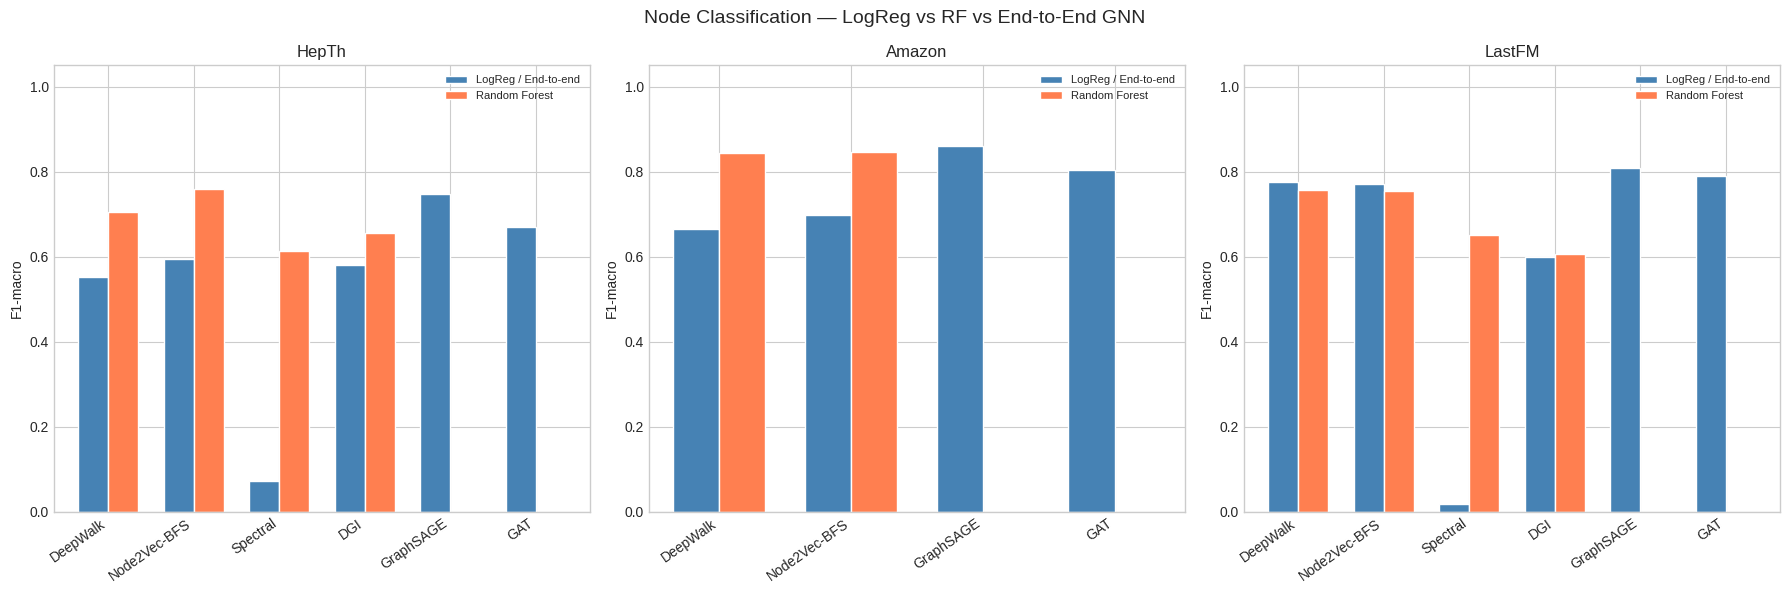

In [59]:
# ═══════════════════════════════════════════
# 7.3 — NC Visualization
# ═══════════════════════════════════════════
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Node Classification — LogReg vs RF vs End-to-End GNN", fontsize=14)

for ax, (ds_name, nc_res) in zip(axes, [("HepTh", nc_hepth), ("Amazon", nc_amazon), ("LastFM", nc_lastfm)]):
    methods, lr_f1, rf_f1 = [], [], []
    for name in ['DeepWalk', 'Node2Vec-BFS', 'Spectral', 'DGI', 'GraphSAGE', 'GAT']:
        if name not in nc_res or nc_res[name] is None: continue
        r = nc_res[name]
        methods.append(name)
        if 'LogReg' in r:
            lr_f1.append(r['LogReg']['f1']); rf_f1.append(r['RF']['f1'])
        else:
            lr_f1.append(r['f1']); rf_f1.append(0)
    x = np.arange(len(methods)); w = 0.35
    ax.bar(x-w/2, lr_f1, w, label='LogReg / End-to-end', color='steelblue', edgecolor='white')
    ax.bar(x+w/2, rf_f1, w, label='Random Forest', color='coral', edgecolor='white')
    ax.set_xticks(x); ax.set_xticklabels(methods, rotation=35, ha='right')
    ax.set_ylabel('F1-macro'); ax.set_title(ds_name); ax.legend(fontsize=8); ax.set_ylim(0, 1.05)
plt.tight_layout(); plt.savefig('nc_comparison.png', dpi=150, bbox_inches='tight'); plt.show()

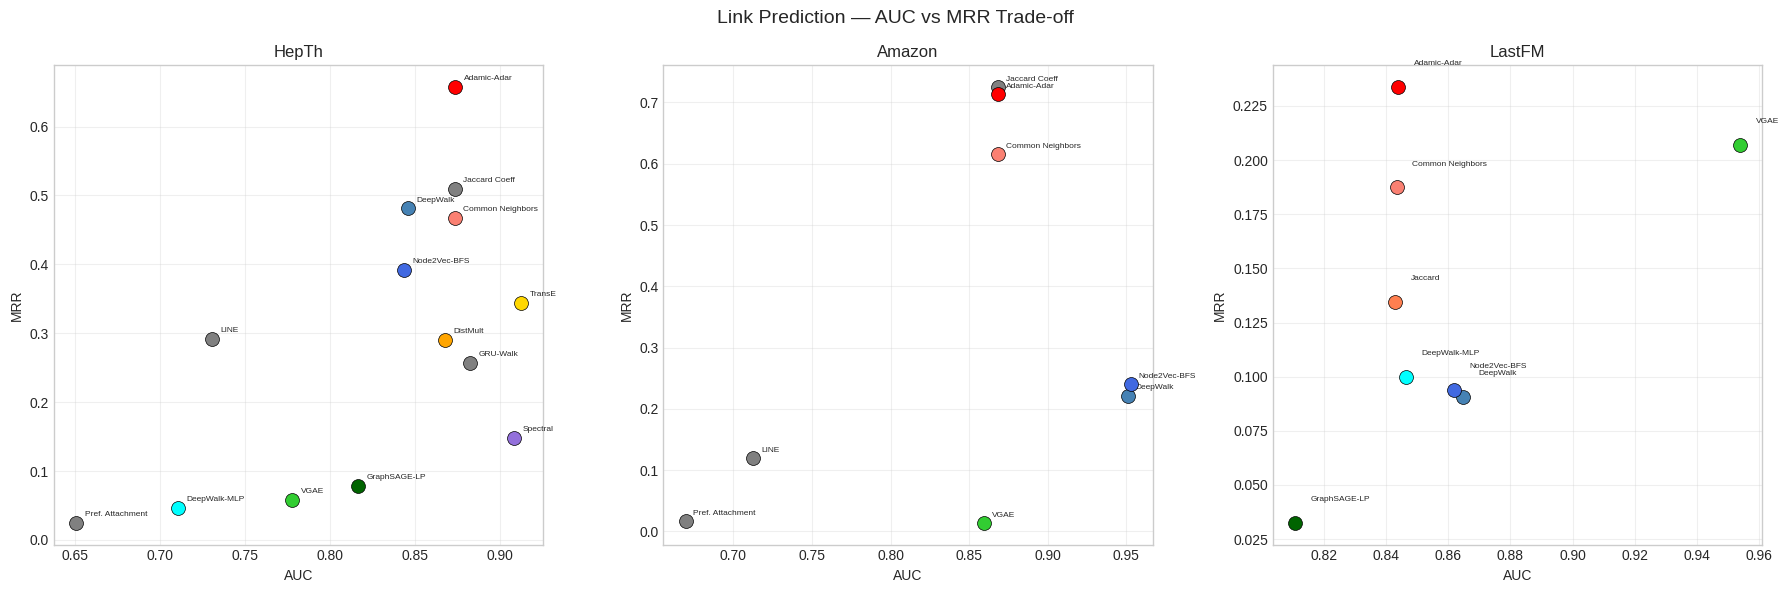

In [60]:
# ═══════════════════════════════════════════
# 7.4 — LP Visualization: AUC vs MRR
# ═══════════════════════════════════════════
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Link Prediction — AUC vs MRR Trade-off", fontsize=14)

colors = {'DeepWalk':'steelblue','Node2Vec-BFS':'royalblue','Spectral':'mediumpurple',
          'TransE':'gold','DistMult':'orange','VGAE':'limegreen',
          'Common Neighbors':'salmon','Jaccard':'coral','Adamic-Adar':'red',
          'GraphSAGE-LP':'darkgreen','DeepWalk-MLP':'cyan'}

for ax, (ds_name, lp_res) in zip(axes, [("HepTh", lp_hepth), ("Amazon", lp_amazon), ("LastFM", lp_lastfm)]):
    for name, r in lp_res.items():
        c = colors.get(name, 'gray')
        ax.scatter(r.get('auc',0), r.get('mrr',0), s=100, c=c, edgecolors='k', lw=0.5, zorder=5)
        ax.annotate(name, (r.get('auc',0)+0.005, r.get('mrr',0)+0.01), fontsize=6)
    ax.set_xlabel("AUC"); ax.set_ylabel("MRR"); ax.set_title(ds_name); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig('lp_auc_vs_mrr.png', dpi=150, bbox_inches='tight'); plt.show()

---
# Part 8 — Embedding Visualization (UMAP)

2D projections of embedding spaces, colored by ground-truth labels. This gives a visual sense of whether the embedding captures class structure. Clear clusters = the embedding naturally separates classes. Mixed colors = the embedding learned something else (e.g. structural roles instead of community membership).

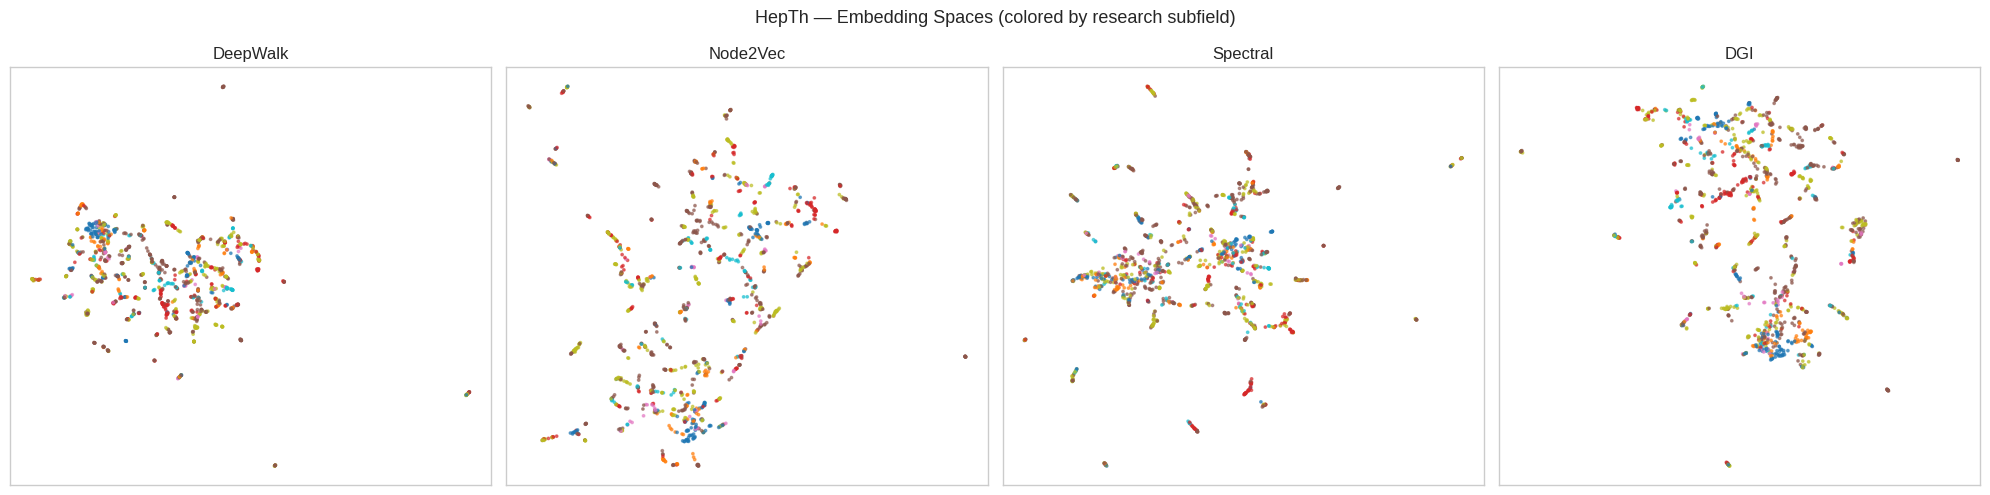

In [61]:
# ═══════════════════════════════════════════
# 8.1 — UMAP on HepTh embeddings
# ═══════════════════════════════════════════
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("HepTh — Embedding Spaces (colored by research subfield)", fontsize=13)
emb_sets = [('DeepWalk', hepth_dw), ('Node2Vec', hepth_n2v_bfs), ('Spectral', hepth_spectral)]
if 'dgi_hepth_emb' in dir(): emb_sets.append(('DGI', dgi_hepth_emb))

for ax, (name, emb) in zip(axes, emb_sets):
    nodes = [n for n in hepth_labeled_nodes if n in emb]
    X = np.array([emb[n] for n in nodes])
    y = np.array([hepth_labels[hepth_labeled_nodes.index(n)] for n in nodes])
    X2 = umap.UMAP(random_state=SEED).fit_transform(X)
    ax.scatter(X2[:,0], X2[:,1], c=y, cmap='tab10', s=3, alpha=0.6)
    ax.set_title(name); ax.set_xticks([]); ax.set_yticks([])
for i in range(len(emb_sets), 4): axes[i].axis('off')
plt.tight_layout(); plt.savefig('umap_hepth.png', dpi=150, bbox_inches='tight'); plt.show()

---
# Part 9 — What we found

1. The downstream predictor matters as much as the embedding.

On HepTh, switching from LogReg to Random Forest on the exact same Node2Vec embedding pushes F1 from 0.59 to 0.76 — a 17-point jump without touching the embedding at all. On Amazon, the same switch gives +18 points (0.70 to 0.85). This happens because random walk embeddings optimize for graph proximity, not class separation, so class boundaries in embedding space are nonlinear. RF handles that; LogReg draws straight lines and misses.

On LastFM (the only dataset with real features), this pattern reverses: DeepWalk with LogReg (0.78) actually beats RF (0.76). When the embedding already aligns well with the task, a simpler classifier does just fine.

2. AUC and MRR measure different things, and the rankings flip.

On Amazon LP, Node2Vec leads on AUC (0.95) but Jaccard leads on MRR (0.73 vs 0.24). Embeddings produce smooth, well-calibrated scores that work well for binary classification (AUC), but heuristics produce sparse, decisive scores where the correct edge often ranks first (MRR). Reporting only AUC would make embeddings look dominant; reporting only MRR would make heuristics look dominant. Both are needed.

3. Real content features change the game.

VGAE on HepTh/Amazon (structural features only): AUC around 0.78-0.86, MRR below 0.06. VGAE on LastFM (real artist preferences): AUC = 0.95, MRR = 0.21 — the best LP result on that dataset by a wide margin. When you give the model actual content to work with, the variational reconstruction objective becomes much more effective. GraphSAGE similarly jumps from F1 = 0.75 on HepTh to 0.81 on LastFM for NC.

4. KGE embeddings are not great for node classification.

TransE and DistMult were trained to model edge structure (translation and bilinear scoring). Their embeddings do fine for LP (TransE leads HepTh LP with AUC = 0.91), but when fed to classifiers for NC they underperform: F1 = 0.41-0.47 on HepTh vs 0.70-0.76 for Node2Vec. The training objective just does not align with class separation. This is expected but worth confirming empirically.

5. DGI is competitive but not consistently so.

On HepTh, DGI (self-supervised, no labels) reaches F1 = 0.58/0.66 (LogReg/RF) — within range of DeepWalk (0.55/0.70). On LastFM it drops to 0.60, below DeepWalk's 0.78. The contrastive objective captures some community structure but not enough to match walk-based methods, especially when real features are available.

6. Spectral embeddings have a scalability wall.

Works on HepTh (10K nodes, runs in seconds), barely converges on LastFM (7.6K nodes, needed solver tweaking), impossible on Amazon (335K nodes). When it does work, the results are mixed: decent LP on HepTh (AUC = 0.91) but poor NC (LogReg F1 = 0.07, RF = 0.61). The eigenvectors capture global graph structure well for link prediction but don't map cleanly to class labels with a linear classifier.

7. GRU-Walk: mixed results.

On HepTh LP, GRU-Walk achieves AUC = 0.88 with notably strong Hits@10 (0.74), competitive with Adamic-Adar. On LastFM NC, it performs at 0.75 (LogReg), slightly below DeepWalk's 0.78. Replacing Word2Vec with a GRU does not consistently improve over the simpler Skip-Gram approach. The sequential structure in walks may not carry enough additional signal to justify the heavier model.

8. What we would recommend in practice.

For a new graph with no features: start with Node2Vec + RF. It's fast, needs no labels for the embedding, and the RF handles nonlinear boundaries. On both HepTh and Amazon, this combination (F1 = 0.76 and 0.85) is close to the supervised GNNs (0.75 and 0.86), without requiring any label-dependent training.

For a graph with real node features: use GraphSAGE. The feature information pushes it clearly ahead of everything else (0.81 on LastFM vs 0.78 for the best unsupervised method).

For link prediction: always include heuristic baselines (Adamic-Adar, Jaccard). They consistently dominate on MRR across all three datasets and require zero training. Combine with a learned method (VGAE if you have features, Node2Vec otherwise) for the best AUC.
